# Pneumonia detection from 3 channel RGB x-ray images

## The dataset

The dataset is a popular dataset found on Kaggle [chest-xray-pneumonia](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), comprising 5,863 X-Ray images (JPEG) in 2 categories (Pneumonia/Normal). The dataset has been the focus of several competitions, and referenced in literature, with several studies claiming accuracy, recall, and precision all above 90%. Such models are often trained with extremely deep networks, with large compute power, and very advanced training techniques. For example, the DenseNet201 network contains around 20 million parameters. I aim to see if similar metrics are achievable with each of these parameters scaled down.  

The dataset contains an imbalanced dataset, with far more incidences of signal (pneumonia) than noise (normal). This creates difficulties in training the network, as loss functions in their default state encourage the network to predict the presence of signal in all / most images. It also creates difficulties in assessing the performance of a model, as accuracy. For example, if there are 80 pneumonia images, and 20 normal images, and the model predicts that all images inputted show pneumonia, which would achieve an accuracy of 80%, despite misclassifying 20% of samples. Thus, several metrics are used in this project to assess each model's performance:

<br>
<br>

## Accuracy

$$
    Accuracy = \frac{Number \, of \, Correct \, Predictions}{Total \, Number \, of \, Predictions} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Where: 

- $TP$ = True Positives: Instances correctly identified as positives.  
- $TN$ = True Negatives: Instances correctly identified as negatives.  
- $FP$ = False Pasitives: Instances incorrectly predicted as positive.  
- $FN$ = False Negatives: Instances incorrectly predicted as negative.  

<br>
<br>

## Recall (Sensitivity in medical contexts)

$$
    Recall = \frac{TP}{TP + FN}
$$

Where the symbols have the same meaning as above.  

Recall measures the proportion of positive cases that were correctly identified as positive.  

In medical contexts, high recall means that most people who have a condition are correctly diagnosed as such.  

<br>
<br>


## Precision

$$
    Precision = \frac{TP}{TP + FP}
$$

Where the symbols have the same meaning as above.  

Precision measures the proportion of positive predictions that were actually correct.

<br>
<br>

## F1 Score

$$
    F1 \, Score = 2 \times \frac{Precision \times Recall}{Precision + Recall}
$$


F1 Score is the harmonic mean of Recall and Precision, and is particularly useful when dealing with an imbalanced dataset (imbalanced classes). 

<br>
<br>

## True Negative Rate (Specificity in medical contexts)

<br>
<br>

$$
    TNR = \frac{TN}{TN + FP}
$$

Where $TNR$ is the True Negative Rate.

In medical contexts, a high TNR means there are fewer false positives. As such, fewer people are misdiagnosed with a condtion.  

Given that the consequences of getting a false negative are very severe (pneumonia being undetected and untreated), and the consequences of a false positive less harmful (another test being performed to confirm accuracy), in medical fields, recall (sensitivity) is often a prioritised metric, although the TNR (specificity) is important too.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, gc, json, shutil, glob
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Disabled GPU as Apple has still not fixed GPU implementation in tensorflow - been reported for several years!
tf.config.set_visible_devices([], 'GPU') 

# Data exploration and dataset creation

In [2]:
IMAGES_PATH = './chest_xray/chest_xray/'
TRAIN_PATH = os.path.join(IMAGES_PATH, 'train')
VAL_PATH = os.path.join(IMAGES_PATH, 'val')
TEST_PATH = os.path.join(IMAGES_PATH, 'test')

In [3]:
for dirpath, dirnames, filenames in os.walk(IMAGES_PATH):
    print(f'The directory {dirpath} contains {len(dirnames)} directories and {len(filenames)} files')

The directory ./chest_xray/chest_xray/ contains 3 directories and 1 files
The directory ./chest_xray/chest_xray/test contains 2 directories and 1 files
The directory ./chest_xray/chest_xray/test/PNEUMONIA contains 0 directories and 390 files
The directory ./chest_xray/chest_xray/test/NORMAL contains 0 directories and 234 files
The directory ./chest_xray/chest_xray/train contains 2 directories and 1 files
The directory ./chest_xray/chest_xray/train/PNEUMONIA contains 0 directories and 3876 files
The directory ./chest_xray/chest_xray/train/NORMAL contains 0 directories and 1342 files
The directory ./chest_xray/chest_xray/val contains 2 directories and 1 files
The directory ./chest_xray/chest_xray/val/PNEUMONIA contains 0 directories and 9 files
The directory ./chest_xray/chest_xray/val/NORMAL contains 0 directories and 9 files


In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_PATH, image_size=(224, 224)).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(VAL_PATH, image_size=(224, 224)).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_PATH, image_size=(224, 224), shuffle=False).prefetch(tf.data.AUTOTUNE)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


## View images

In [50]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

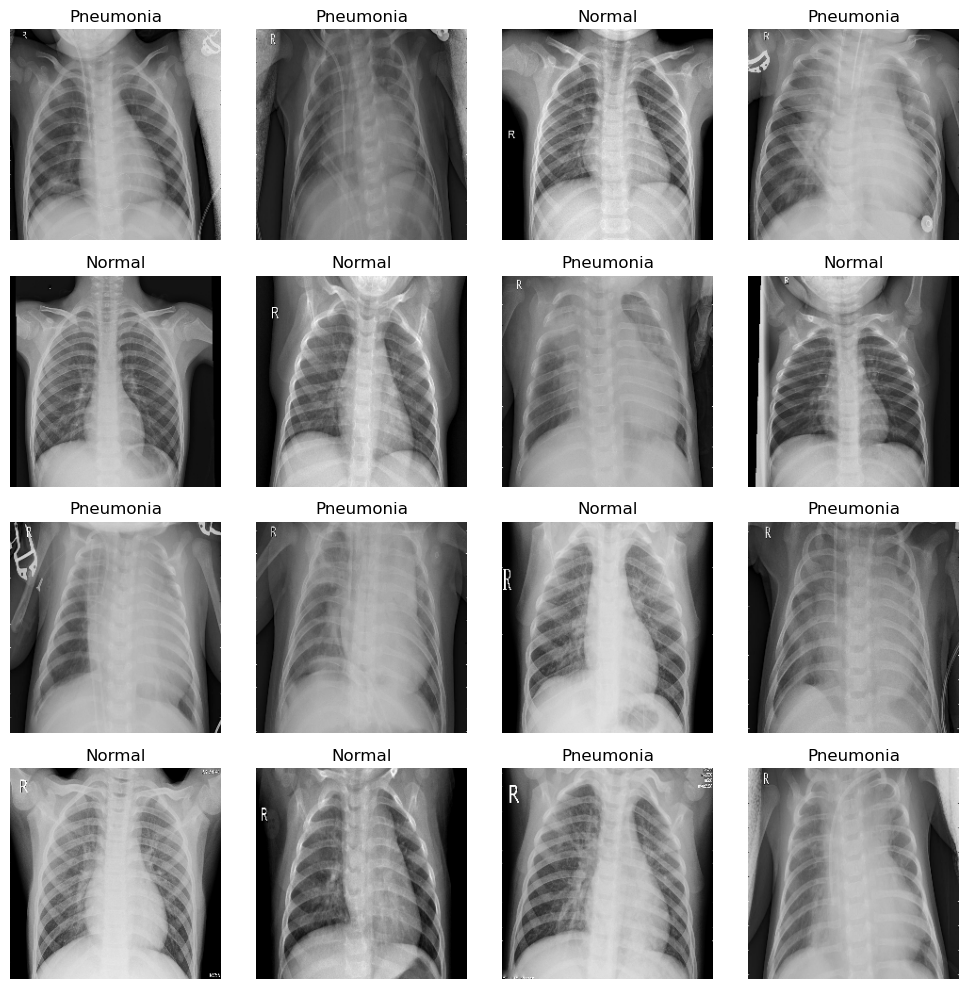

In [51]:
rows, cols = 4, 4
plt.figure(figsize=(10, 10))

# Taking the first batch
for images, labels in val_dataset.take(1):
    # Display the first 'rows * cols' images
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        # Display the image
        plt.imshow(images[i].numpy().astype('uint8'))
        # Set the title to 'Pneumonia' or 'Normal' based on the label
        plt.title(f'{"Pneumonia" if labels[i] == 1 else "Normal"}')
        plt.axis('off')

plt.tight_layout()
plt.show()

# Balance classes to create more validation samples

In [52]:
# find number of files in a directory
def find_num_files(directory):
    num_files = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        image_files = [file for file in filenames if file.endswith('.jpeg')]
        num_files += len(filenames)
    return num_files

image_filenames = glob.glob('/path/to/directory/*.jpeg')


TEST_NORMAL_PATH = os.path.join(TEST_PATH, 'NORMAL')
TEST_PNEUMONIA_PATH = os.path.join(TEST_PATH, 'PNEUMONIA')
VAL_NORMAL_PATH = os.path.join(VAL_PATH, 'NORMAL')
VAL_PNEUMONIA_PATH = os.path.join(VAL_PATH, 'PNEUMONIA')

if find_num_files(TEST_NORMAL_PATH) >= 233:
    image_filenames = glob.glob(f'{TEST_NORMAL_PATH}/*.jpeg')
    image_filenames = np.random.choice(image_filenames, int(0.45*233), replace=False)
    for image_filename in image_filenames:
        shutil.move(image_filename, VAL_NORMAL_PATH)
        
if find_num_files(TEST_PNEUMONIA_PATH) >= 390:
    image_filenames = glob.glob(f'{TEST_PNEUMONIA_PATH}/*.jpeg')
    image_filenames = np.random.choice(image_filenames, int(0.45*390), replace=False)
    for image_filename in image_filenames:
        shutil.move(image_filename, VAL_PNEUMONIA_PATH)

In [53]:
for dirpath, dirnames, filenames in os.walk(IMAGES_PATH):
    print(f'The directory {dirpath} contains {len(dirnames)} directories and {len(filenames)} files')

The directory ./chest_xray/chest_xray/ contains 3 directories and 1 files
The directory ./chest_xray/chest_xray/test contains 2 directories and 1 files
The directory ./chest_xray/chest_xray/test/PNEUMONIA contains 0 directories and 215 files
The directory ./chest_xray/chest_xray/test/NORMAL contains 0 directories and 130 files
The directory ./chest_xray/chest_xray/train contains 2 directories and 1 files
The directory ./chest_xray/chest_xray/train/PNEUMONIA contains 0 directories and 3876 files
The directory ./chest_xray/chest_xray/train/NORMAL contains 0 directories and 1342 files
The directory ./chest_xray/chest_xray/val contains 2 directories and 1 files
The directory ./chest_xray/chest_xray/val/PNEUMONIA contains 0 directories and 184 files
The directory ./chest_xray/chest_xray/val/NORMAL contains 0 directories and 113 files


In [4]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_PATH, image_size=(224, 224)).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(VAL_PATH, image_size=(224, 224)).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_PATH, image_size=(224, 224), shuffle=False).prefetch(tf.data.AUTOTUNE)

Found 5216 files belonging to 2 classes.
Found 295 files belonging to 2 classes.
Found 345 files belonging to 2 classes.


In [4]:
# Check dataset correctly determined class names
tf.keras.preprocessing.image_dataset_from_directory(TRAIN_PATH, image_size=(224, 224)).class_names

Found 5216 files belonging to 2 classes.


['NORMAL', 'PNEUMONIA']

# Set up helper functions

In [34]:
class HelperFunctions:
    
    '''
    A class to hold all the helper functions for the project
    
    Methods:
    -------------------
    model_history_plotter(model_history: tf.keras.callbacks.History, model_name: str)
        Plots the model history for the given model
        
    model_evaluator(model: tf.keras.Model, test_dataset: tf.data.Dataset)
        Evaluates model against test dataset and updates / creates model_results.json file with the results.
    
    delete_model_gc(model: tf.keras.Model)
        Deletes the model, clears Keras backend session and runs garbage collection.
    '''


    @staticmethod
    def model_history_plotter(model_history: tf.keras.callbacks.History, model_name: str):
        
        '''
        Plots the model history for the given model
        
        Parameters:
        --------------------
        model_history: tf.keras.callbacks.History
            The history of the model
        model_name: str
            The name of the model
        
        Returns:
        --------------------
        None
        '''
        
        fig, ax1 = plt.subplots(figsize=(10, 7))
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.plot(model_history.history['loss'], label='loss', color='blue')

        ax2 = ax1.twinx()
        ax2.set_ylabel('val_accuracy / accuracy / val_loss')
        ax2.plot(model_history.history['val_loss'], label='val_loss', color='red')
        ax2.plot(model_history.history['accuracy'], label='accuracy', color='green')
        ax2.plot(model_history.history['val_accuracy'], label='val_accuracy', color='yellow')
        fig.legend(loc="upper right")
        ax2.set_title(model_name)
        plt.show()
        
    @staticmethod
    def model_evaluator(model: tf.keras.Model, test_dataset: tf.data.Dataset, model_name: str|None = None):
    
        '''
        Evaluates model against test dataset and updates / creates model_results.json file with the results.
        
        Parameters:
        -------------------
        model: tf.keras.Model
            The model to be evaluated.
        test_dataset: tf.data.Dataset
            The test dataset to be used for evaluation.
        model_name: str
            The name of the model to be used. If None, the model's name is used.
        
        Returns:
        -------------------
        None
        '''
        
        model_probs = model.predict(test_dataset)
        print(f'Model probability predictions (first 10): {tf.squeeze(model_probs[:10])}')
        
        model_preds = tf.squeeze(tf.round(model_probs)).numpy().astype('int32')
        
        y_true = np.concatenate([y for x, y in test_dataset])
        print(f"True labels (first 10): {y_true[:10]}")
        precision, recall, f_score, _ = precision_recall_fscore_support(y_true=y_true, y_pred=model_preds, average='binary')
        false_positive_metric = tf.keras.metrics.FalsePositives()
        false_positive_metric.update_state(y_true, model_preds)
        false_positive = false_positive_metric.result().numpy()
        
        true_negative_metric = tf.keras.metrics.TrueNegatives()
        true_negative_metric.update_state(y_true, model_preds)
        true_negative = true_negative_metric.result().numpy()
        
        true_negative_rate = true_negative / (true_negative + false_positive) 
        
        accuracy = model.evaluate(test_dataset)[-1]
        print('Sklearn accuracy score:', accuracy_score(y_true, model_preds))
        
        if model_name is None: name = model.name
        else: name = model_name

        model_results = {
            name: {
                'precision': precision,
                'recall': recall,
                'f_score': f_score,
                'accuracy': accuracy,
                'true_negative_rate': true_negative_rate
            }
        }
        
        print(model_results)
        
        if not os.path.exists('model_results.json'):
            with open('model_results.json', 'w') as f:
                json.dump(model_results, f, indent=4, default=HelperFunctions.converter)

        else:
            with open('model_results.json', 'r+') as f:
                data = json.load(f)
                data.update(model_results)
                f.seek(0)
                json.dump(data, f, indent=4, default=HelperFunctions.converter)
                f.truncate()
                
        ConfusionMatrixDisplay.from_predictions(y_true, model_preds, display_labels=['Normal', 'Pneumonia'])
        plt.show()
        
    @staticmethod
    def converter(obj):
        if isinstance(obj, (np.float32, tf.float32)):
            return float(obj)
                
                
    @staticmethod
    def clear_backend_gc():
        
        '''
        Clears Keras backend session and runs garbage collection.
        
        Useful when training many models using one Python kernel.
        
        Parameters:
        -------------------
        None
        
        Returns:
        -------------------
        None
        '''
        
        tf.keras.backend.clear_session()
        gc.collect()

# Model 1: Fully dense model

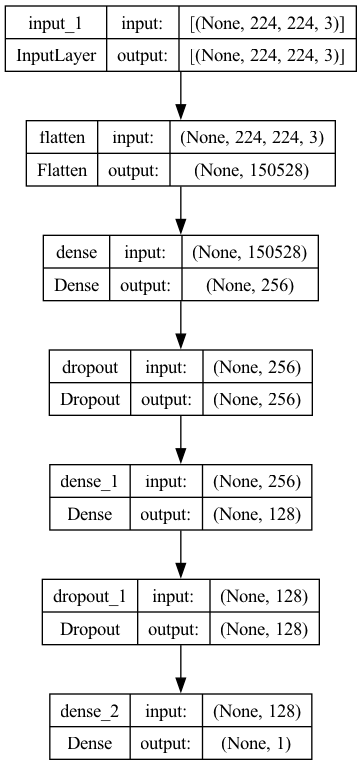

In [6]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs, name='model_1_fully_dense')

model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tf.keras.utils.plot_model(model_1, show_shapes=True)

In [7]:
model_1_history = model_1.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(model_1.name, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2)
    ]
)

Epoch 1/50


163/163 [==============================] - ETA: 0s - loss: 1697.8196 - accuracy: 0.7115INFO:tensorflow:Assets written to: model_1_fully_dense/assets


INFO:tensorflow:Assets written to: model_1_fully_dense/assets


163/163 [==============================] - 10s 57ms/step - loss: 1697.8196 - accuracy: 0.7115 - val_loss: 0.6665 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 2/50
162/163 [============================>.] - ETA: 0s - loss: 5.7964 - accuracy: 0.7425INFO:tensorflow:Assets written to: model_1_fully_dense/assets


INFO:tensorflow:Assets written to: model_1_fully_dense/assets


163/163 [==============================] - 9s 56ms/step - loss: 5.7645 - accuracy: 0.7427 - val_loss: 0.6583 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 3/50
162/163 [============================>.] - ETA: 0s - loss: 5.0749 - accuracy: 0.7429INFO:tensorflow:Assets written to: model_1_fully_dense/assets


INFO:tensorflow:Assets written to: model_1_fully_dense/assets


163/163 [==============================] - 10s 58ms/step - loss: 5.0475 - accuracy: 0.7429 - val_loss: 0.6581 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 9s 53ms/step - loss: 0.5899 - accuracy: 0.7429 - val_loss: 0.6625 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 5/50
163/163 [==============================] - 9s 54ms/step - loss: 0.6200 - accuracy: 0.7421 - val_loss: 0.6644 - val_accuracy: 0.6203 - lr: 0.0010
Epoch 6/50
163/163 [==============================] - 10s 57ms/step - loss: 0.5780 - accuracy: 0.7429 - val_loss: 0.6650 - val_accuracy: 0.6203 - lr: 1.0000e-04


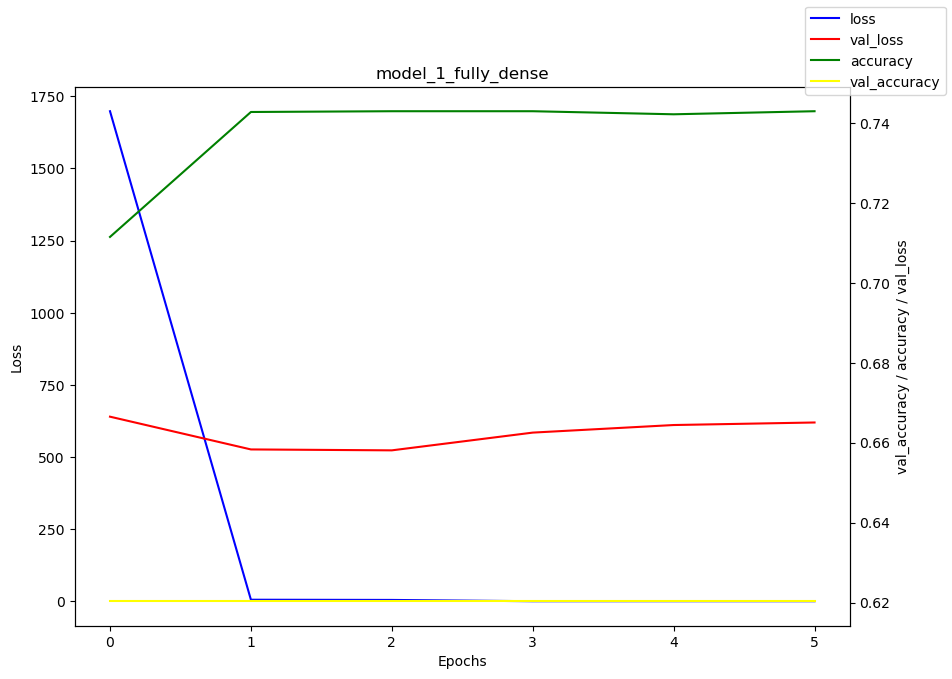

In [8]:
HelperFunctions.model_history_plotter(model_1_history, model_1.name)

11/11 [==============================] - 0s 23ms/step
Model probability predictions (first 10): [0.6334768 0.6334768 0.6334768 0.6334768 0.6334768 0.6334768 0.6334768
 0.6334768 0.6334768 0.6334768]


True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
11/11 [==============================] - 0s 21ms/step - loss: 0.6574 - accuracy: 0.6232
Sklearn accuracy score: 0.6231884057971014
{'model_1_fully_dense': {'precision': 0.6231884057971014, 'recall': 1.0, 'f_score': 0.7678571428571429, 'accuracy': 0.6231883764266968, 'true_negative_rate': 0.0}}


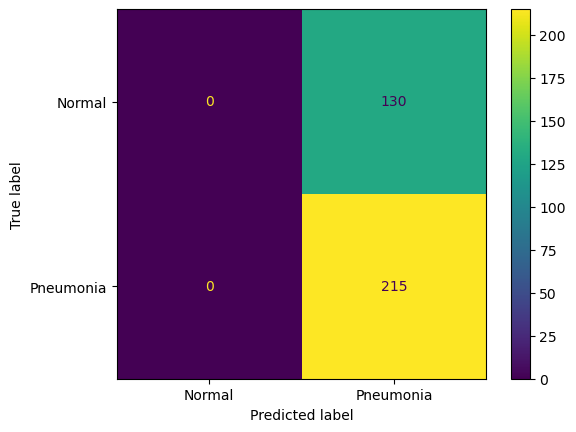

In [14]:
model_1_loaded = tf.keras.models.load_model('model_1_fully_dense')
HelperFunctions.model_evaluator(model_1_loaded, test_dataset, model_1_loaded.name)

In [15]:
np.unique(np.squeeze(model_1_loaded.predict(test_dataset)), return_counts=True)

11/11 [==============================] - 0s 22ms/step


(array([0.6334768, 1.       ], dtype=float32), array([341,   4]))

***

It seems like the model is always predicting the same probabilities, possibly due to the dataset being imbalanced. This is a very odd result - we need to try a different model.  

It is predicting that every image is indicative of pneumonia - a problem of having an imbalanced dataset where most images are signal (pneumonia).  

This is an example of why relying on one metric is incorrect methodology when evaluating models. Our recall is 1, but our model is predicting all samples as showing pneumonia.  

***

In [11]:
del model_1
HelperFunctions.clear_backend_gc()

In [16]:
del model_1_loaded
HelperFunctions.clear_backend_gc()

# Model 2: CNN

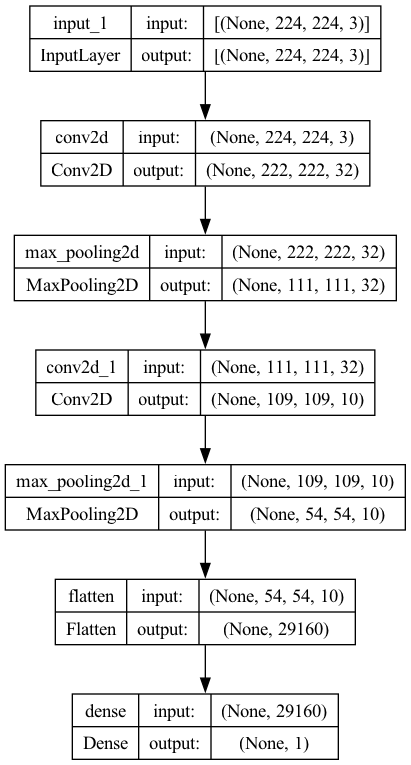

In [12]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(10, 3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, x, name='model_2_convolutional')
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tf.keras.utils.plot_model(model_2, show_shapes=True)

In [13]:
model_2_history = model_2.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(model_2.name, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2)
])

Epoch 1/50
163/163 [==============================] - ETA: 0s - loss: 1.7176 - accuracy: 0.8520INFO:tensorflow:Assets written to: model_2_convolutional/assets


INFO:tensorflow:Assets written to: model_2_convolutional/assets


163/163 [==============================] - 30s 182ms/step - loss: 1.7176 - accuracy: 0.8520 - val_loss: 1.0008 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - 29s 178ms/step - loss: 0.2423 - accuracy: 0.9156 - val_loss: 1.3544 - val_accuracy: 0.6915 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - 29s 178ms/step - loss: 0.1445 - accuracy: 0.9500 - val_loss: 1.2147 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 29s 179ms/step - loss: 0.0536 - accuracy: 0.9812 - val_loss: 1.5983 - val_accuracy: 0.7153 - lr: 1.0000e-04


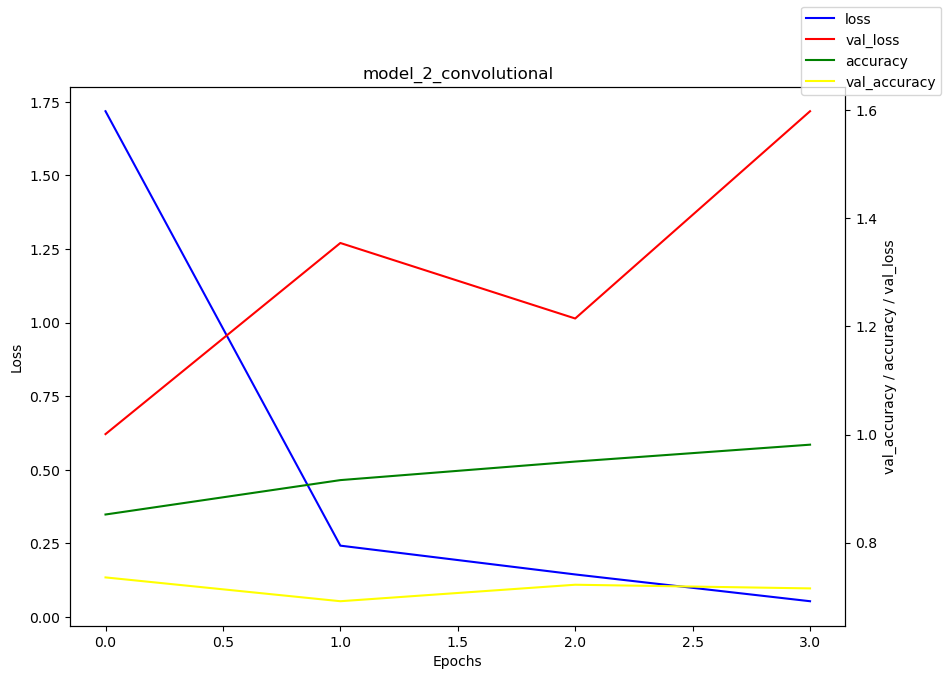

In [14]:
HelperFunctions.model_history_plotter(model_2_history, model_2.name)

11/11 [==============================] - 1s 48ms/step
Model probability predictions (first 10): [0.9884563  0.814569   0.16779901 0.8401235  0.7506479  0.9989834
 0.94460696 0.85179025 0.6030484  0.00239581]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
11/11 [==============================] - 1s 49ms/step - loss: 1.0339 - accuracy: 0.7565
Sklearn accuracy score: 0.7565217391304347
{'model_2_convolutional': {'precision': 0.7235494880546075, 'recall': 0.986046511627907, 'f_score': 0.8346456692913385, 'accuracy': 0.7565217614173889, 'true_negative_rate': 0.37692308}}


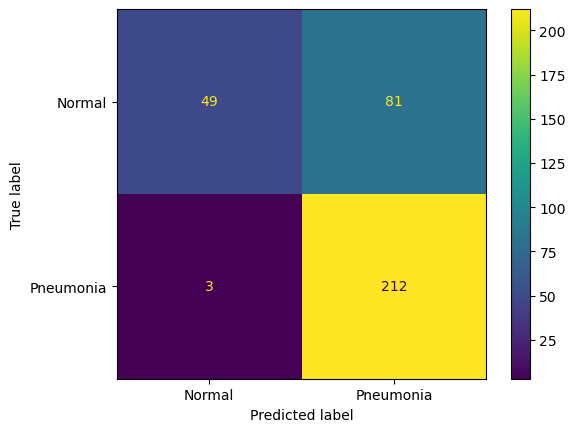

In [18]:
model_2_loaded = tf.keras.models.load_model('model_2_convolutional')
HelperFunctions.model_evaluator(model_2_loaded, test_dataset, model_2_loaded.name)

In [15]:
del model_2
HelperFunctions.clear_backend_gc()

In [19]:
del model_2_loaded
HelperFunctions.clear_backend_gc()

***

Model is overfitting to train dataset, and still affected by imbalance of classes.  

Let's try the same model, with:  
- Dropout layers to prevent overfitting  
- Training data augmentation to create more training samples  
- Weights to account for the imbalance of classes

***

# Model 3: CNN with dropout, augmentation, weights for class imbalance

## Show imbalance of classes

In [16]:
num_0, num_1 = 0, 0
for features, labels in train_dataset:
    labels = labels.numpy()
    num_0 += np.unique(labels, return_counts=True)[1][0]
    num_1 += np.unique(labels, return_counts=True)[1][1]

print(f'Number of normal photos in training dataset: {num_0}')
print(f'Number of pneumonia photos in training dataset: {num_1}')

Number of normal photos in training dataset: 1341
Number of pneumonia photos in training dataset: 3875


## Compute class weights

In [38]:
train_labels = []
for features, labels in train_dataset:
    labels = labels.numpy()
    train_labels.extend(labels)

In [39]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=train_labels)
class_weights

array([1.9448173 , 0.67303226])

## Create model

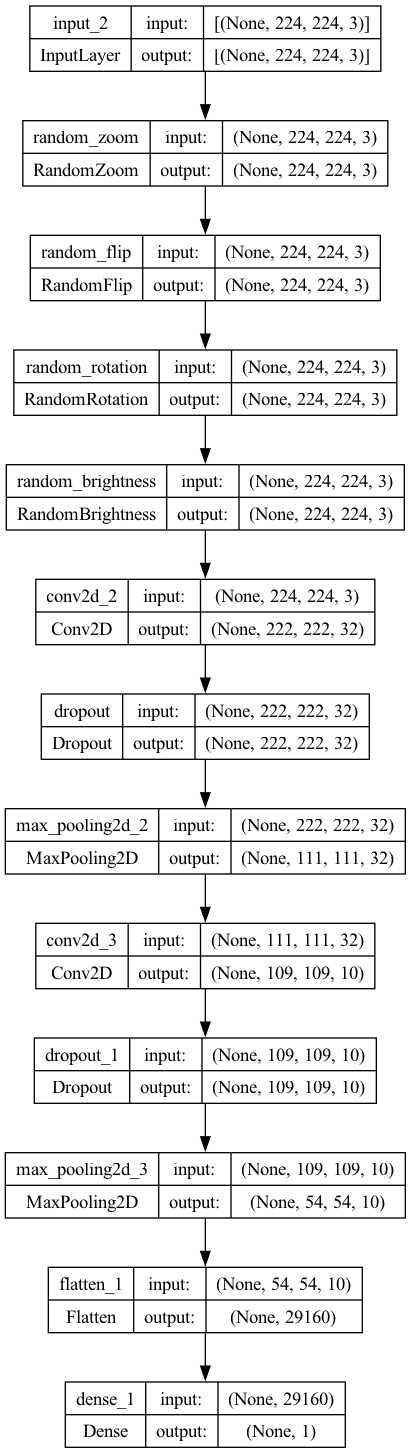

In [18]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.RandomZoom(0.2)(inputs)
x = tf.keras.layers.RandomFlip('horizontal')(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomBrightness(0.2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(10, 3, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_3 = tf.keras.Model(inputs, outputs, name='model_3_CNN_augmentation_dropout_weighted')

model_3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tf.keras.utils.plot_model(model_3, show_shapes=True)

In [40]:
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [22]:
model_3_history = model_3.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(model_3.name, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2)
], class_weight=class_weights_dict)

Epoch 1/50


163/163 [==============================] - ETA: 0s - loss: 5.1389 - accuracy: 0.4166INFO:tensorflow:Assets written to: model_3_CNN_augmentation_dropout_weighted/assets


INFO:tensorflow:Assets written to: model_3_CNN_augmentation_dropout_weighted/assets


163/163 [==============================] - 42s 251ms/step - loss: 5.1389 - accuracy: 0.4166 - val_loss: 0.6655 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 2/50
163/163 [==============================] - 40s 241ms/step - loss: 0.6693 - accuracy: 0.6476 - val_loss: 0.6801 - val_accuracy: 0.6644 - lr: 0.0010
Epoch 3/50
163/163 [==============================] - 41s 248ms/step - loss: 0.6511 - accuracy: 0.6580 - val_loss: 0.6828 - val_accuracy: 0.6610 - lr: 0.0010
Epoch 4/50
163/163 [==============================] - 42s 254ms/step - loss: 0.6455 - accuracy: 0.6693 - val_loss: 0.6919 - val_accuracy: 0.6881 - lr: 1.0000e-04


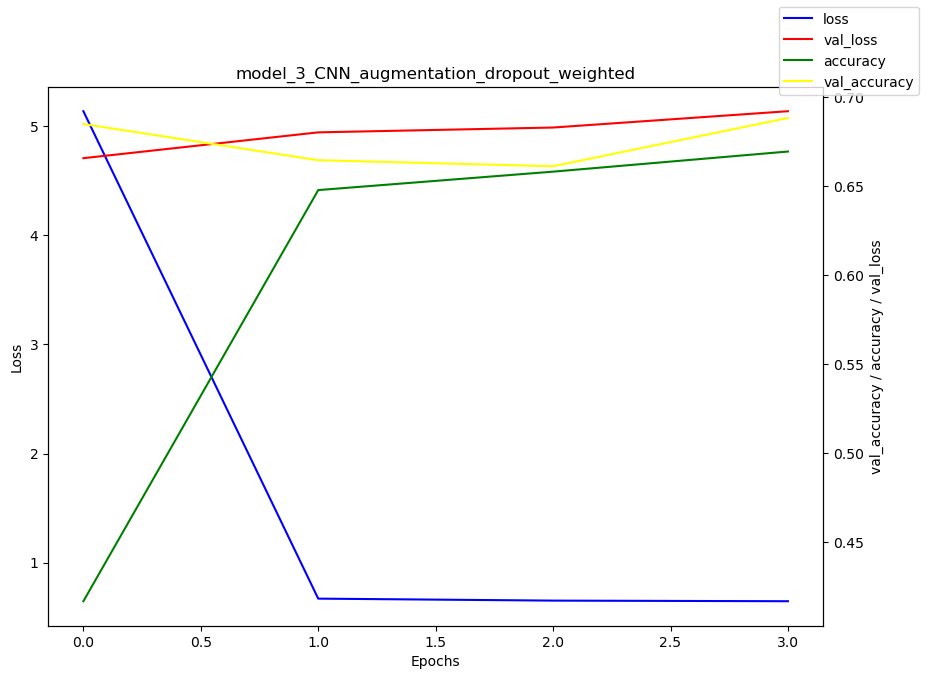

In [23]:
HelperFunctions.model_history_plotter(model_3_history, model_3.name)

11/11 [==============================] - 1s 51ms/step
Model probability predictions (first 10): [0.5012307  0.5012307  0.5132423  0.6085859  0.50580716 0.6482601
 0.5185279  0.5012307  0.5012307  0.5415502 ]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
11/11 [==============================] - 1s 49ms/step - loss: 0.7170 - accuracy: 0.6377
Sklearn accuracy score: 0.6376811594202898
{'model_3_CNN_augmentation_dropout_weighted': {'precision': 0.6991150442477876, 'recall': 0.7348837209302326, 'f_score': 0.7165532879818595, 'accuracy': 0.6376811861991882, 'true_negative_rate': 0.47692308}}


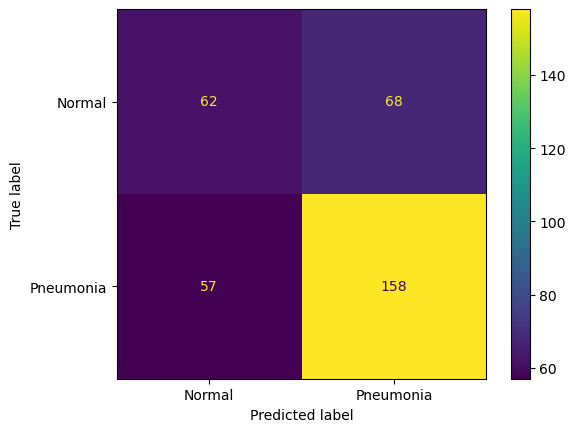

In [20]:
model_3_loaded = tf.keras.models.load_model('model_3_CNN_augmentation_dropout_weighted')
HelperFunctions.model_evaluator(model_3_loaded, test_dataset)

In [25]:
del model_3
HelperFunctions.clear_backend_gc()

In [21]:
del model_3_loaded
HelperFunctions.clear_backend_gc()

***

Model is no longer significantly overfitting, however is classifying too many normal photos as being that of signal.  

Let's try a more complex model, and scale the image data to floats 0-255. Most networks perform better when inputs are in the range of (-1, 1) or (0, 1)

***

# Model 4: More complex CNN with dropout, weighted classes, scaled image data

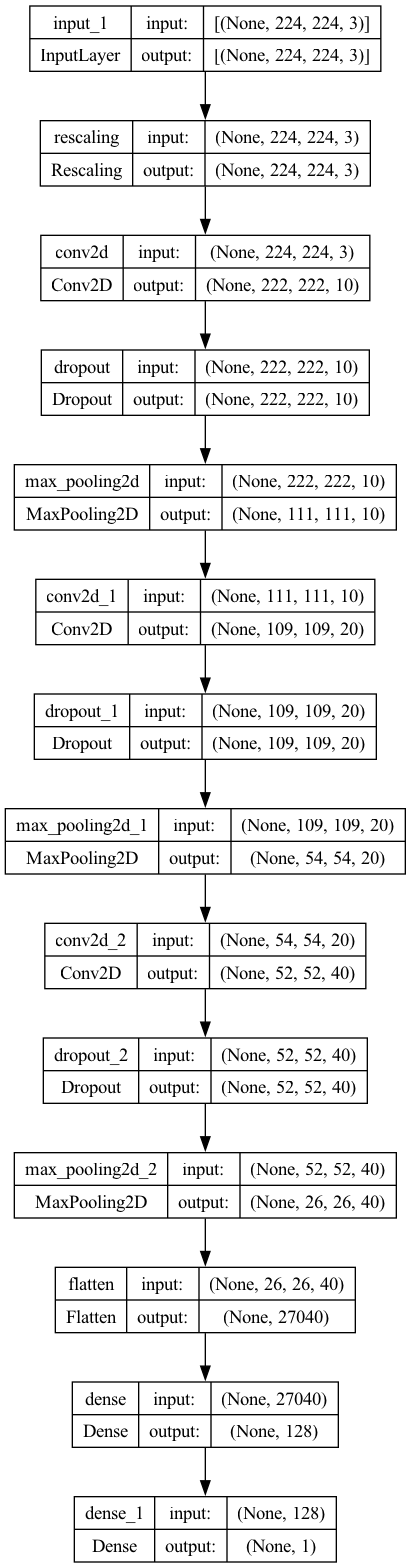

In [26]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.Conv2D(10, 3, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(20, 3, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(40, 3, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, outputs, name='model_4_Medium_CNN_weighted_dropout_scaled')

model_4.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])
tf.keras.utils.plot_model(model_4, show_shapes=True)

In [27]:
model_4_history = model_4.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(model_4.name, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2)
    ], class_weight=class_weights_dict)

Epoch 1/50


163/163 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.7770INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


163/163 [==============================] - 30s 176ms/step - loss: 0.5515 - accuracy: 0.7770 - val_loss: 0.5849 - val_accuracy: 0.7864 - lr: 1.0000e-05
Epoch 2/50
163/163 [==============================] - ETA: 0s - loss: 0.3704 - accuracy: 0.8842INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


163/163 [==============================] - 30s 181ms/step - loss: 0.3704 - accuracy: 0.8842 - val_loss: 0.4890 - val_accuracy: 0.8678 - lr: 1.0000e-05
Epoch 3/50
163/163 [==============================] - ETA: 0s - loss: 0.2773 - accuracy: 0.9110INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


163/163 [==============================] - 30s 184ms/step - loss: 0.2773 - accuracy: 0.9110 - val_loss: 0.4381 - val_accuracy: 0.8712 - lr: 1.0000e-05
Epoch 4/50
163/163 [==============================] - ETA: 0s - loss: 0.2301 - accuracy: 0.9227INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


163/163 [==============================] - 30s 180ms/step - loss: 0.2301 - accuracy: 0.9227 - val_loss: 0.4095 - val_accuracy: 0.8475 - lr: 1.0000e-05
Epoch 5/50
163/163 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.9385INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


163/163 [==============================] - 30s 180ms/step - loss: 0.1890 - accuracy: 0.9385 - val_loss: 0.3858 - val_accuracy: 0.8508 - lr: 1.0000e-05
Epoch 6/50
163/163 [==============================] - 29s 174ms/step - loss: 0.1701 - accuracy: 0.9413 - val_loss: 0.3957 - val_accuracy: 0.8169 - lr: 1.0000e-05
Epoch 7/50
163/163 [==============================] - 29s 176ms/step - loss: 0.1562 - accuracy: 0.9452 - val_loss: 0.3964 - val_accuracy: 0.8034 - lr: 1.0000e-05
Epoch 8/50
163/163 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9532INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


INFO:tensorflow:Assets written to: model_4_Medium_CNN_weighted_dropout_scaled/assets


163/163 [==============================] - 30s 181ms/step - loss: 0.1431 - accuracy: 0.9532 - val_loss: 0.3642 - val_accuracy: 0.8373 - lr: 1.0000e-06
Epoch 9/50
163/163 [==============================] - 29s 173ms/step - loss: 0.1404 - accuracy: 0.9517 - val_loss: 0.3686 - val_accuracy: 0.8373 - lr: 1.0000e-06
Epoch 10/50
163/163 [==============================] - 28s 171ms/step - loss: 0.1403 - accuracy: 0.9540 - val_loss: 0.3663 - val_accuracy: 0.8339 - lr: 1.0000e-06
Epoch 11/50
163/163 [==============================] - 28s 170ms/step - loss: 0.1384 - accuracy: 0.9540 - val_loss: 0.3657 - val_accuracy: 0.8339 - lr: 1.0000e-07


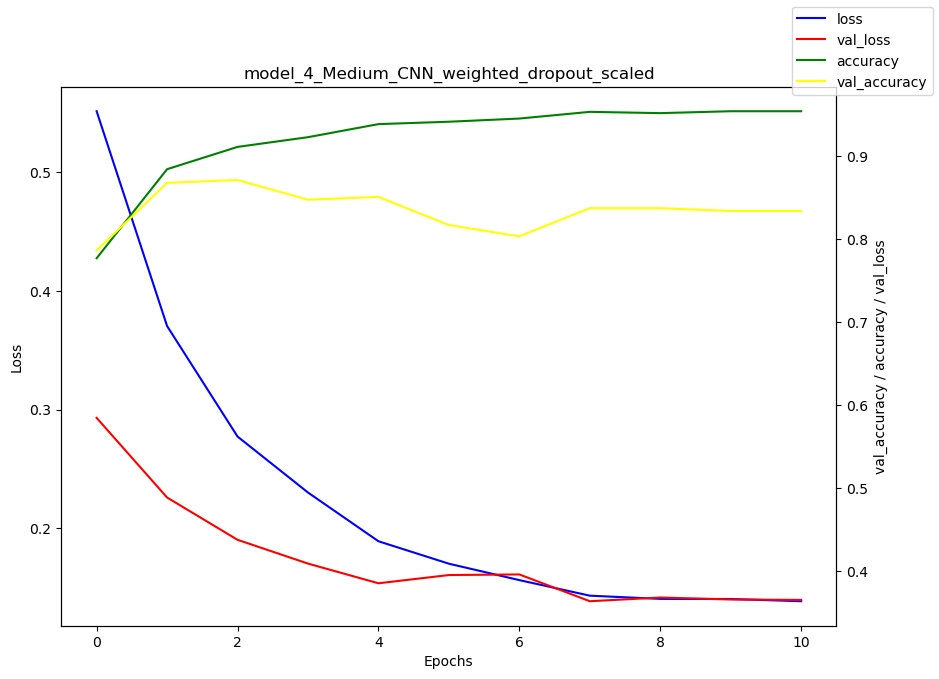

In [28]:
HelperFunctions.model_history_plotter(model_4_history, model_4.name)

11/11 [==============================] - 1s 43ms/step
Model probability predictions (first 10): [0.5671991  0.800737   0.18600313 0.42369473 0.51030463 0.42218173
 0.36718923 0.4167761  0.669974   0.09257336]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
11/11 [==============================] - 1s 47ms/step - loss: 0.3920 - accuracy: 0.7971
Sklearn accuracy score: 0.7971014492753623
{'model_4_Medium_CNN_weighted_dropout_scaled': {'precision': 0.7695167286245354, 'recall': 0.9627906976744186, 'f_score': 0.8553719008264463, 'accuracy': 0.7971014380455017, 'true_negative_rate': 0.52307695}}


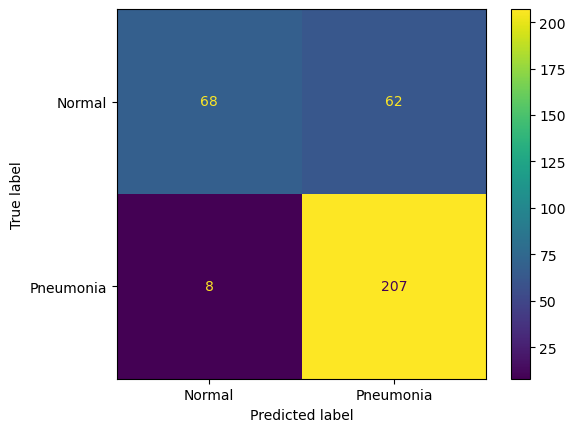

In [22]:
model_4_loaded = tf.keras.models.load_model('model_4_Medium_CNN_weighted_dropout_scaled')
HelperFunctions.model_evaluator(model_4_loaded, test_dataset)

In [30]:
del model_4
HelperFunctions.clear_backend_gc()

In [23]:
del model_4_loaded
HelperFunctions.clear_backend_gc()

*** 

Model is learning the features well.  

However, let's try to diversify the dataset to give more training data, increase validation scores, and prevent overfitting.  

We can do this through image augmentation, similar to in model 3.  

Let's also increase the patience on EarlyStopping, to allow the learning rate sufficient chance to descend for finer tuning.  

Note - since this model became unstable with increasing complexity and regularisation:  

- Batch normalisation layers were attempted.  
- Different optimisers, such as SGD, were attempted.  
- Model was kept reasonably simple, with few augmentation layers.  
- Batch size was increased to 128 to increase stability during gradient descent.  

***

# Model 5: Simple CNN with augmentation, dropout, rescaling, class weights

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_PATH, image_size=(224, 224), batch_size=128).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(VAL_PATH, image_size=(224, 224), batch_size=128).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(TEST_PATH, image_size=(224, 224), batch_size=128, shuffle=False).prefetch(tf.data.AUTOTUNE)

Found 5216 files belonging to 2 classes.
Found 295 files belonging to 2 classes.
Found 345 files belonging to 2 classes.


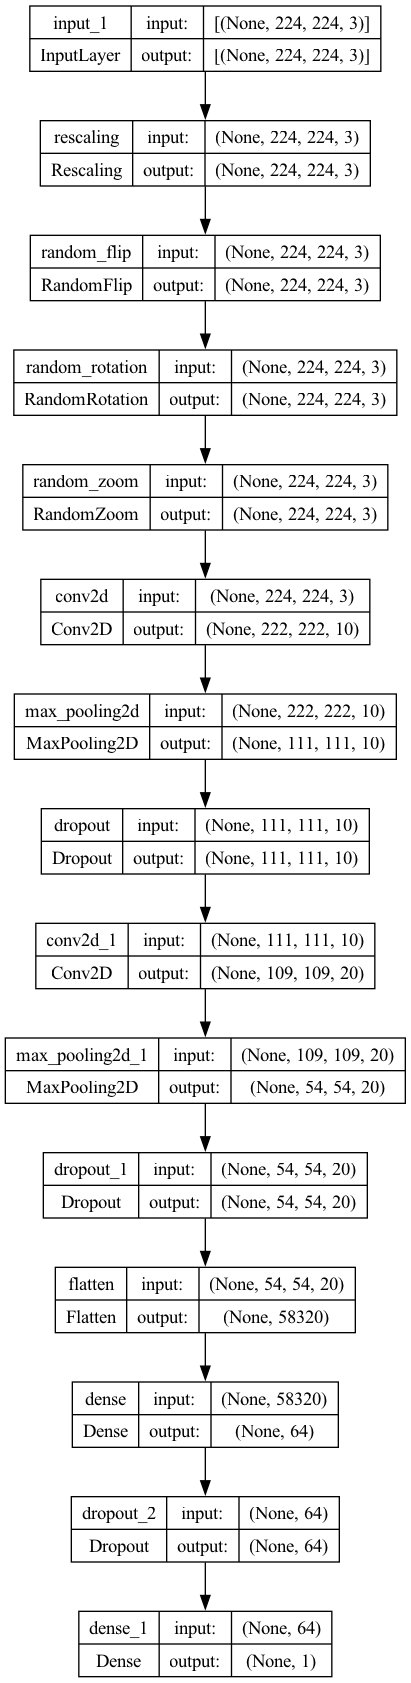

In [32]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = tf.keras.layers.RandomFlip('horizontal')(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.05)(x)
x = tf.keras.layers.Conv2D(10, 3, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(20, 3, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.Model(inputs, outputs, name='model_5_Simple_CNN_augmentation_dropout_weighted_scaled')
model_5.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(), metrics=['accuracy'])

tf.keras.utils.plot_model(model_5, show_shapes=True)

In [92]:
model_5_history = model_5.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2),
    tf.keras.callbacks.ModelCheckpoint(model_5.name, save_best_only=True)
    ], class_weight=class_weights_dict)

Epoch 1/50


41/41 [==============================] - ETA: 0s - loss: 1.1067 - accuracy: 0.4666INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 25s 559ms/step - loss: 1.1067 - accuracy: 0.4666 - val_loss: 0.6929 - val_accuracy: 0.6102 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.6647INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 24s 551ms/step - loss: 0.6803 - accuracy: 0.6647 - val_loss: 0.6925 - val_accuracy: 0.6712 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.6505 - accuracy: 0.6342INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 24s 558ms/step - loss: 0.6505 - accuracy: 0.6342 - val_loss: 0.6627 - val_accuracy: 0.6847 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - ETA: 0s - loss: 0.5385 - accuracy: 0.7111INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 24s 557ms/step - loss: 0.5385 - accuracy: 0.7111 - val_loss: 0.5572 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.7841INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 24s 559ms/step - loss: 0.4450 - accuracy: 0.7841 - val_loss: 0.5187 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - ETA: 0s - loss: 0.4119 - accuracy: 0.8029INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 24s 556ms/step - loss: 0.4119 - accuracy: 0.8029 - val_loss: 0.4737 - val_accuracy: 0.7695 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - ETA: 0s - loss: 0.3635 - accuracy: 0.8238INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 24s 561ms/step - loss: 0.3635 - accuracy: 0.8238 - val_loss: 0.4570 - val_accuracy: 0.8136 - lr: 0.0010
Epoch 8/50
41/41 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8353INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 24s 558ms/step - loss: 0.3561 - accuracy: 0.8353 - val_loss: 0.4544 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 9/50
41/41 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8292INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 24s 558ms/step - loss: 0.3627 - accuracy: 0.8292 - val_loss: 0.4351 - val_accuracy: 0.8169 - lr: 0.0010
Epoch 10/50
41/41 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.8602INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


INFO:tensorflow:Assets written to: model_5_Simple_CNN_augmentation_dropout_weighted_scaled/assets


41/41 [==============================] - 24s 553ms/step - loss: 0.3293 - accuracy: 0.8602 - val_loss: 0.3954 - val_accuracy: 0.8339 - lr: 0.0010
Epoch 11/50
41/41 [==============================] - 23s 531ms/step - loss: 0.3111 - accuracy: 0.8685 - val_loss: 0.4832 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 12/50
41/41 [==============================] - 23s 533ms/step - loss: 0.3074 - accuracy: 0.8656 - val_loss: 0.4403 - val_accuracy: 0.7763 - lr: 0.0010
Epoch 13/50
41/41 [==============================] - 24s 542ms/step - loss: 0.2997 - accuracy: 0.8767 - val_loss: 0.4229 - val_accuracy: 0.7797 - lr: 1.0000e-04
Epoch 14/50
41/41 [==============================] - 23s 543ms/step - loss: 0.2860 - accuracy: 0.8846 - val_loss: 0.4370 - val_accuracy: 0.7763 - lr: 1.0000e-04


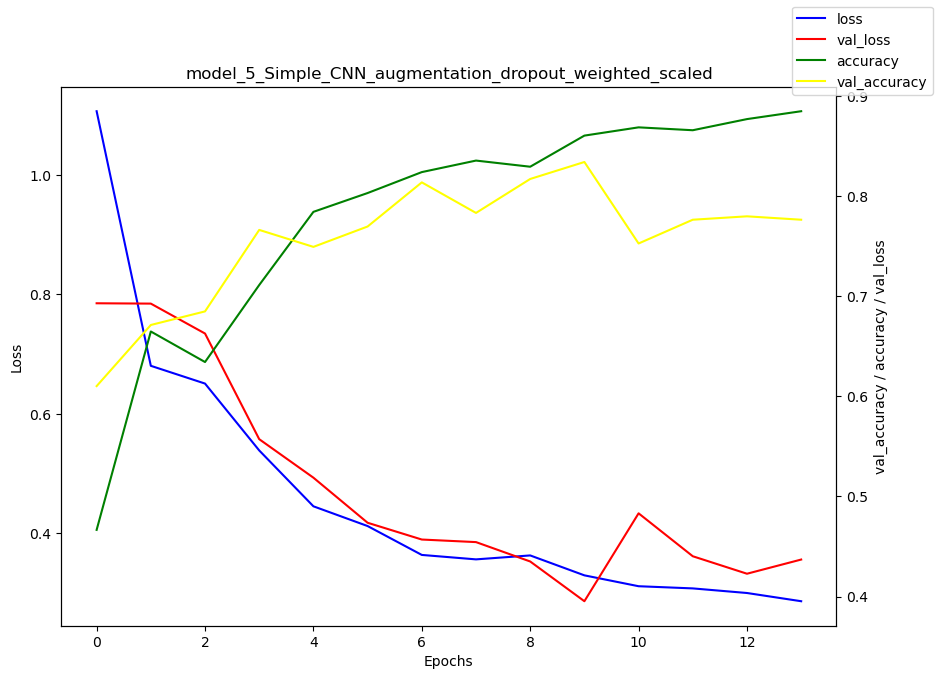

In [93]:
HelperFunctions.model_history_plotter(model_5_history, model_5.name)

In [106]:
del(model_5)
HelperFunctions.clear_backend_gc()

3/3 [==============================] - 1s 107ms/step
Model probability predictions (first 10): [0.45799953 0.7833295  0.08620873 0.19878444 0.2981379  0.22656502
 0.19558893 0.38737056 0.4296407  0.02634987]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
3/3 [==============================] - 1s 111ms/step - loss: 0.3867 - accuracy: 0.8348
Sklearn accuracy score: 0.8347826086956521
{'model_5_Simple_CNN_augmentation_dropout_weighted_scaled': {'precision': 0.8910891089108911, 'recall': 0.8372093023255814, 'f_score': 0.8633093525179856, 'accuracy': 0.834782600402832, 'true_negative_rate': 0.83076924}}


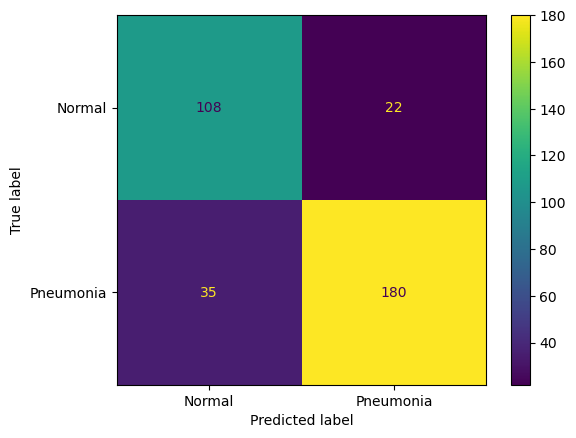

In [25]:
model_5_load_best_weights = tf.keras.models.load_model('model_5_Simple_CNN_augmentation_dropout_weighted_scaled')
HelperFunctions.model_evaluator(model_5_load_best_weights, test_dataset)

In [26]:
del(model_5_load_best_weights)
HelperFunctions.clear_backend_gc()

***

An accuracy of 83%. Not bad, but I think a better result can be achieved. Our other metrics are looking good too.  

A big improvement here is that people without pneumonia are less likely to be predicted as having pneumonia.  

It seems like dropout layers, augmentation, class weights, and a relatively simple model give reasonable results.  

***

# Model 6: EffecientNetB0 (transfer learning)

In [35]:
effecient_net = tf.keras.applications.EfficientNetB0(include_top=False)
effecient_net.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = effecient_net(inputs, training=False)
x = tf.keras.layers.GlobalMaxPool2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_6 = tf.keras.Model(inputs, outputs, name='model_6_efficient_net')

model_6.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

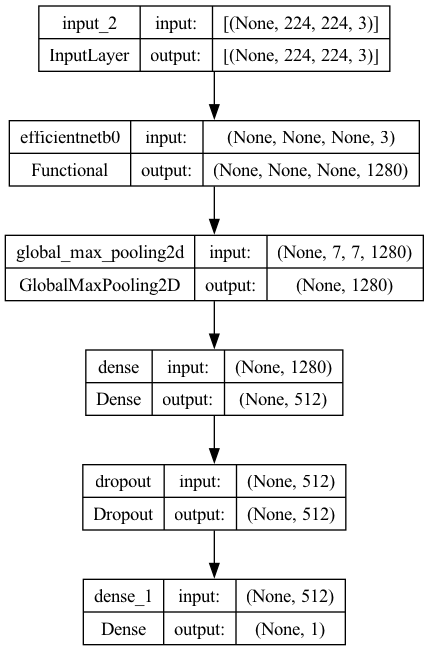

In [36]:
tf.keras.utils.plot_model(model_6, show_shapes=True)

In [37]:
model_6_history = model_6.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2),
    tf.keras.callbacks.ModelCheckpoint(model_6.name, save_best_only=True)
    ], class_weight=class_weights_dict)

Epoch 1/50


41/41 [==============================] - ETA: 0s - loss: 1.1599 - accuracy: 0.7866INFO:tensorflow:Assets written to: model_6_efficient_net/assets


INFO:tensorflow:Assets written to: model_6_efficient_net/assets


41/41 [==============================] - 74s 2s/step - loss: 1.1599 - accuracy: 0.7866 - val_loss: 0.4376 - val_accuracy: 0.8136 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9151INFO:tensorflow:Assets written to: model_6_efficient_net/assets


INFO:tensorflow:Assets written to: model_6_efficient_net/assets


41/41 [==============================] - 69s 2s/step - loss: 0.2110 - accuracy: 0.9151 - val_loss: 0.3635 - val_accuracy: 0.8339 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.9346INFO:tensorflow:Assets written to: model_6_efficient_net/assets


INFO:tensorflow:Assets written to: model_6_efficient_net/assets


41/41 [==============================] - 68s 2s/step - loss: 0.1553 - accuracy: 0.9346 - val_loss: 0.3317 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 49s 1s/step - loss: 0.1393 - accuracy: 0.9431 - val_loss: 0.3954 - val_accuracy: 0.8305 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9471INFO:tensorflow:Assets written to: model_6_efficient_net/assets


INFO:tensorflow:Assets written to: model_6_efficient_net/assets


41/41 [==============================] - 69s 2s/step - loss: 0.1255 - accuracy: 0.9471 - val_loss: 0.2996 - val_accuracy: 0.8780 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 50s 1s/step - loss: 0.1083 - accuracy: 0.9548 - val_loss: 0.5460 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 7/50
41/41 [==============================] - 46s 1s/step - loss: 0.0995 - accuracy: 0.9603 - val_loss: 0.5181 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 8/50
41/41 [==============================] - 49s 1s/step - loss: 0.0891 - accuracy: 0.9640 - val_loss: 0.4094 - val_accuracy: 0.8576 - lr: 1.0000e-04


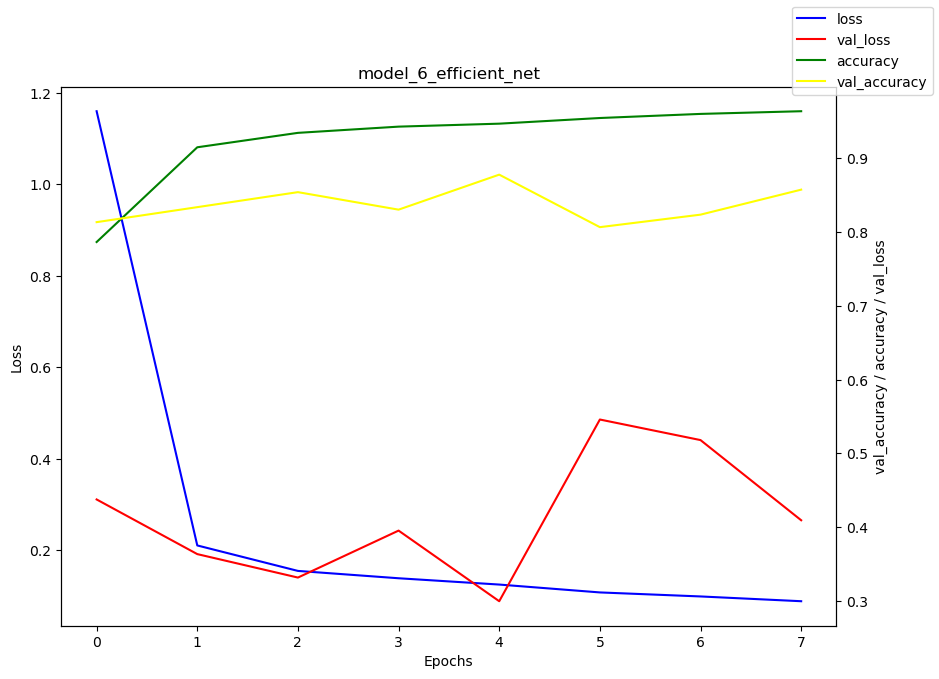

In [38]:
HelperFunctions.model_history_plotter(model_6_history, model_6.name)

3/3 [==============================] - 4s 922ms/step
Model probability predictions (first 10): [0.06977423 0.16236658 0.40026355 0.22743636 0.69921035 0.0439428
 0.14703836 0.6049006  0.5484128  0.06317677]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
3/3 [==============================] - 4s 894ms/step - loss: 0.3736 - accuracy: 0.8435
Sklearn accuracy score: 0.8434782608695652
{'model_6_efficient_net': {'precision': 0.8207171314741036, 'recall': 0.958139534883721, 'f_score': 0.8841201716738197, 'accuracy': 0.843478262424469, 'true_negative_rate': 0.65384614}}


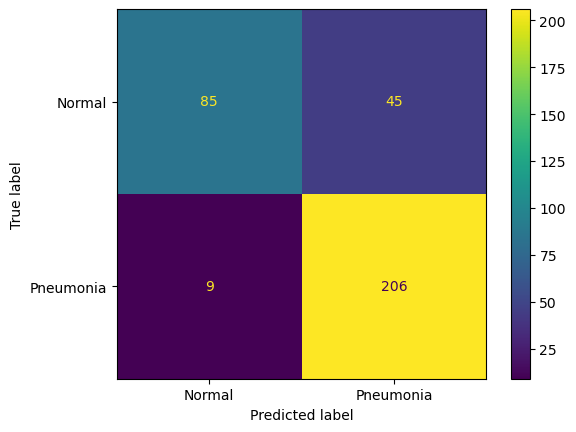

In [27]:
model_6_loaded = tf.keras.models.load_model('model_6_efficient_net')
HelperFunctions.model_evaluator(model_6_loaded, test_dataset)

In [40]:
del model_6
HelperFunctions.clear_backend_gc()

In [29]:
del model_6_loaded
HelperFunctions.clear_backend_gc()

***

Our metrics look good, especially on the model loaded with the best weights.  

However, we still have a lot of healthy people being classified as having pneumonia.  

Let's run our EfficientNet again with regularisation and augmentation.  

***

# Model 7: EfficientNetB0 with increased regularisation & augmentation

## Build model

In [64]:
effecient_net = tf.keras.applications.EfficientNetB0(include_top=False)
effecient_net.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.RandomBrightness(0.2)(inputs)
x = tf.keras.layers.RandomFlip('horizontal')(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)
x = effecient_net(x, training=False)
x = tf.keras.layers.GlobalMaxPool2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_7 = tf.keras.Model(inputs, outputs, name='model_7_efficient_net')

model_7.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

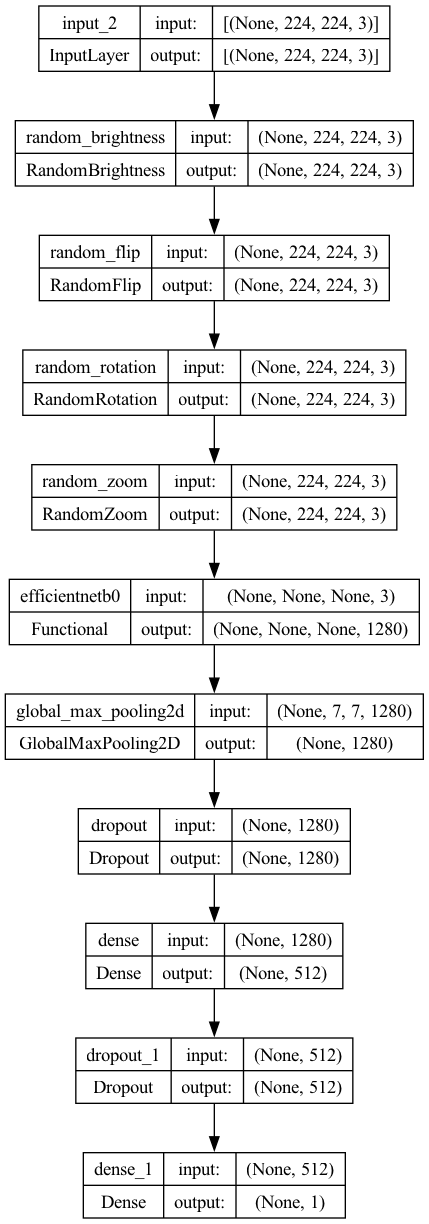

In [65]:
tf.keras.utils.plot_model(model_7, show_shapes=True)

In [66]:
model_7_history = model_7.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2),
    tf.keras.callbacks.ModelCheckpoint(model_7.name, save_best_only=True)
    ], class_weight=class_weights_dict)

Epoch 1/50


41/41 [==============================] - ETA: 0s - loss: 1.1598 - accuracy: 0.7306INFO:tensorflow:Assets written to: model_7_efficient_net/assets


INFO:tensorflow:Assets written to: model_7_efficient_net/assets


41/41 [==============================] - 77s 2s/step - loss: 1.1598 - accuracy: 0.7306 - val_loss: 0.4515 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - 51s 1s/step - loss: 0.4387 - accuracy: 0.8123 - val_loss: 0.4553 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.3906 - accuracy: 0.8261INFO:tensorflow:Assets written to: model_7_efficient_net/assets


INFO:tensorflow:Assets written to: model_7_efficient_net/assets


41/41 [==============================] - 77s 2s/step - loss: 0.3906 - accuracy: 0.8261 - val_loss: 0.3887 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 53s 1s/step - loss: 0.3656 - accuracy: 0.8388 - val_loss: 0.4489 - val_accuracy: 0.7966 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 52s 1s/step - loss: 0.3458 - accuracy: 0.8455 - val_loss: 0.3889 - val_accuracy: 0.8305 - lr: 0.0010
Epoch 6/50
41/41 [==============================] - 51s 1s/step - loss: 0.3280 - accuracy: 0.8591 - val_loss: 0.4116 - val_accuracy: 0.8237 - lr: 1.0000e-04
Epoch 7/50
41/41 [==============================] - 53s 1s/step - loss: 0.3220 - accuracy: 0.8543 - val_loss: 0.4128 - val_accuracy: 0.8407 - lr: 1.0000e-04
Epoch 8/50
41/41 [==============================] - 53s 1s/step - loss: 0.3040 - accuracy: 0.8643 - val_loss: 0.4106 - val_accuracy: 0.8407 - lr: 1.0000e-05


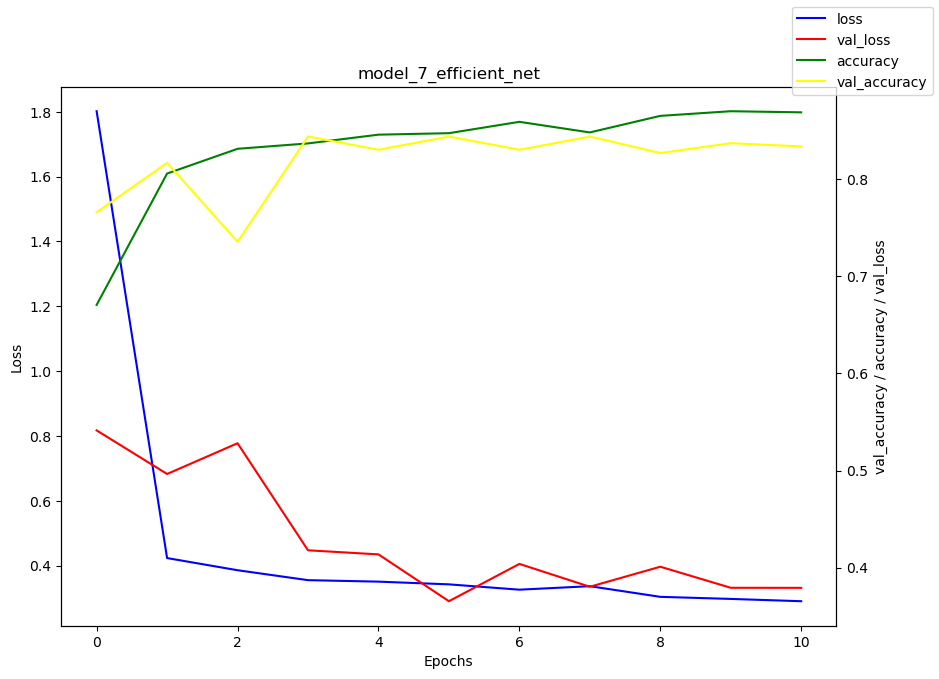

In [27]:
HelperFunctions.model_history_plotter(model_7_history, model_7.name)

In [33]:
del model_7
HelperFunctions.clear_backend_gc()

3/3 [==============================] - 3s 960ms/step
Model probability predictions (first 10): [0.36428753 0.355223   0.5237602  0.3293757  0.52637464 0.6277868
 0.3397749  0.6078789  0.41187987 0.4867278 ]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
3/3 [==============================] - 3s 936ms/step - loss: 0.3920 - accuracy: 0.8377
Sklearn accuracy score: 0.8376811594202899
{'model_7_efficient_net_dropout_augmentation': {'precision': 0.8354430379746836, 'recall': 0.9209302325581395, 'f_score': 0.8761061946902655, 'accuracy': 0.8376811742782593, 'true_negative_rate': 0.7}}


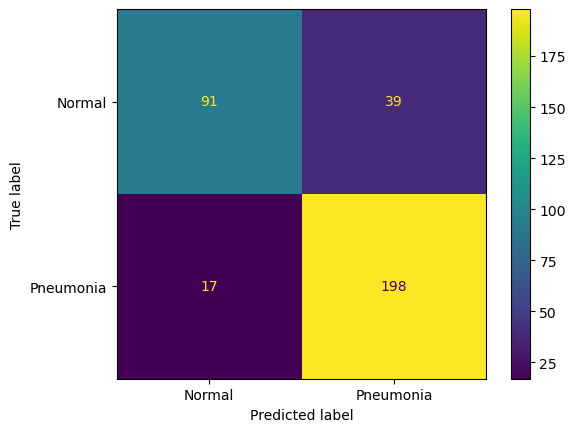

In [31]:
model_7_loaded = tf.keras.models.load_model('model_7_efficient_net')
HelperFunctions.model_evaluator(model_7_loaded, test_dataset, 'model_7_efficient_net_dropout_augmentation')

In [33]:
del model_7_loaded
HelperFunctions.clear_backend_gc()

# Model 8: Fine tune model 7 (reloaded with optimal weights)

In [36]:
model_8 = tf.keras.models.load_model('model_7_efficient_net')

## Make top 10 layers of EfficientNet trainable

In [37]:
model_8.layers

In [39]:
print(f'EfficientNetb0 has {len(model_8.layers[5].layers)} layers')
print(f'EfficientNetB0 has {len(model_8.layers[5].trainable_variables)} trainable variables')

EfficientNetb0 has 238 layers
EfficientNetB0 has 0 trainable variables


In [40]:
model_8.layers[5].trainable = True
for layer in model_8.layers[5].layers[:-20]:
    layer.trainable = False

print(f'EfficientNetb0 has {len(model_8.layers[5].layers)} layers')
print(f'EfficientNetB0 has {len(model_8.layers[5].trainable_variables)} trainable variables')

EfficientNetb0 has 238 layers
EfficientNetB0 has 19 trainable variables


In [41]:
model_8.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])
model_8_history = model_8.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2),
    tf.keras.callbacks.ModelCheckpoint('model_8_efficient_net_fine_tuned', save_best_only=True)
    ], class_weight=class_weights_dict)

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.8583INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 86s 2s/step - loss: 0.3273 - accuracy: 0.8583 - val_loss: 0.3984 - val_accuracy: 0.8373 - lr: 1.0000e-05
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.8645INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 83s 2s/step - loss: 0.3055 - accuracy: 0.8645 - val_loss: 0.3807 - val_accuracy: 0.8508 - lr: 1.0000e-05
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 0.2978 - accuracy: 0.8675INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 83s 2s/step - loss: 0.2978 - accuracy: 0.8675 - val_loss: 0.3775 - val_accuracy: 0.8508 - lr: 1.0000e-05
Epoch 4/50
41/41 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.8750INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 81s 2s/step - loss: 0.2842 - accuracy: 0.8750 - val_loss: 0.3635 - val_accuracy: 0.8542 - lr: 1.0000e-05
Epoch 5/50
41/41 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.8733INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 80s 2s/step - loss: 0.2850 - accuracy: 0.8733 - val_loss: 0.3586 - val_accuracy: 0.8576 - lr: 1.0000e-05
Epoch 6/50
41/41 [==============================] - ETA: 0s - loss: 0.2788 - accuracy: 0.8798INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 86s 2s/step - loss: 0.2788 - accuracy: 0.8798 - val_loss: 0.3581 - val_accuracy: 0.8542 - lr: 1.0000e-05
Epoch 7/50
41/41 [==============================] - ETA: 0s - loss: 0.2608 - accuracy: 0.8865INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 86s 2s/step - loss: 0.2608 - accuracy: 0.8865 - val_loss: 0.3475 - val_accuracy: 0.8576 - lr: 1.0000e-05
Epoch 8/50
41/41 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.8900INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 86s 2s/step - loss: 0.2448 - accuracy: 0.8900 - val_loss: 0.3383 - val_accuracy: 0.8542 - lr: 1.0000e-05
Epoch 9/50
41/41 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.8919INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 81s 2s/step - loss: 0.2494 - accuracy: 0.8919 - val_loss: 0.3342 - val_accuracy: 0.8576 - lr: 1.0000e-05
Epoch 10/50
41/41 [==============================] - ETA: 0s - loss: 0.2385 - accuracy: 0.8984INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 80s 2s/step - loss: 0.2385 - accuracy: 0.8984 - val_loss: 0.3273 - val_accuracy: 0.8644 - lr: 1.0000e-05
Epoch 11/50
41/41 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.8984INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 82s 2s/step - loss: 0.2373 - accuracy: 0.8984 - val_loss: 0.3220 - val_accuracy: 0.8678 - lr: 1.0000e-05
Epoch 12/50
41/41 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9011INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 83s 2s/step - loss: 0.2353 - accuracy: 0.9011 - val_loss: 0.3189 - val_accuracy: 0.8644 - lr: 1.0000e-05
Epoch 13/50
41/41 [==============================] - ETA: 0s - loss: 0.2347 - accuracy: 0.9034INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 81s 2s/step - loss: 0.2347 - accuracy: 0.9034 - val_loss: 0.3146 - val_accuracy: 0.8712 - lr: 1.0000e-05
Epoch 14/50
41/41 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9057INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 82s 2s/step - loss: 0.2236 - accuracy: 0.9057 - val_loss: 0.3093 - val_accuracy: 0.8712 - lr: 1.0000e-05
Epoch 15/50
41/41 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.9086INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 83s 2s/step - loss: 0.2223 - accuracy: 0.9086 - val_loss: 0.3051 - val_accuracy: 0.8712 - lr: 1.0000e-05
Epoch 16/50
41/41 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9061INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 80s 2s/step - loss: 0.2179 - accuracy: 0.9061 - val_loss: 0.3034 - val_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 17/50
41/41 [==============================] - 60s 1s/step - loss: 0.2072 - accuracy: 0.9059 - val_loss: 0.3036 - val_accuracy: 0.8780 - lr: 1.0000e-05
Epoch 18/50
41/41 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.9110INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 84s 2s/step - loss: 0.2045 - accuracy: 0.9110 - val_loss: 0.2919 - val_accuracy: 0.8814 - lr: 1.0000e-05
Epoch 19/50
41/41 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9162INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 85s 2s/step - loss: 0.2050 - accuracy: 0.9162 - val_loss: 0.2917 - val_accuracy: 0.8915 - lr: 1.0000e-05
Epoch 20/50
41/41 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9107INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 85s 2s/step - loss: 0.1987 - accuracy: 0.9107 - val_loss: 0.2848 - val_accuracy: 0.8881 - lr: 1.0000e-05
Epoch 21/50
41/41 [==============================] - 58s 1s/step - loss: 0.1975 - accuracy: 0.9189 - val_loss: 0.2877 - val_accuracy: 0.8949 - lr: 1.0000e-05
Epoch 22/50
41/41 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9191INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 83s 2s/step - loss: 0.1912 - accuracy: 0.9191 - val_loss: 0.2841 - val_accuracy: 0.8949 - lr: 1.0000e-05
Epoch 23/50
41/41 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9195INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 84s 2s/step - loss: 0.1894 - accuracy: 0.9195 - val_loss: 0.2775 - val_accuracy: 0.9085 - lr: 1.0000e-05
Epoch 24/50
41/41 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9137INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 83s 2s/step - loss: 0.1967 - accuracy: 0.9137 - val_loss: 0.2748 - val_accuracy: 0.9051 - lr: 1.0000e-05
Epoch 25/50
41/41 [==============================] - ETA: 0s - loss: 0.1840 - accuracy: 0.9212INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 83s 2s/step - loss: 0.1840 - accuracy: 0.9212 - val_loss: 0.2703 - val_accuracy: 0.8983 - lr: 1.0000e-05
Epoch 26/50
41/41 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9191INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 85s 2s/step - loss: 0.1800 - accuracy: 0.9191 - val_loss: 0.2697 - val_accuracy: 0.9085 - lr: 1.0000e-05
Epoch 27/50
41/41 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9208INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 83s 2s/step - loss: 0.1863 - accuracy: 0.9208 - val_loss: 0.2646 - val_accuracy: 0.9017 - lr: 1.0000e-05
Epoch 28/50
41/41 [==============================] - ETA: 0s - loss: 0.1763 - accuracy: 0.9237INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 80s 2s/step - loss: 0.1763 - accuracy: 0.9237 - val_loss: 0.2635 - val_accuracy: 0.9085 - lr: 1.0000e-05
Epoch 29/50
41/41 [==============================] - 58s 1s/step - loss: 0.1804 - accuracy: 0.9204 - val_loss: 0.2635 - val_accuracy: 0.9119 - lr: 1.0000e-05
Epoch 30/50
41/41 [==============================] - ETA: 0s - loss: 0.1801 - accuracy: 0.9256INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 84s 2s/step - loss: 0.1801 - accuracy: 0.9256 - val_loss: 0.2631 - val_accuracy: 0.9153 - lr: 1.0000e-05
Epoch 31/50
41/41 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9248INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 82s 2s/step - loss: 0.1727 - accuracy: 0.9248 - val_loss: 0.2581 - val_accuracy: 0.9119 - lr: 1.0000e-05
Epoch 32/50
41/41 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9306INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 84s 2s/step - loss: 0.1596 - accuracy: 0.9306 - val_loss: 0.2528 - val_accuracy: 0.9153 - lr: 1.0000e-05
Epoch 33/50
41/41 [==============================] - 57s 1s/step - loss: 0.1674 - accuracy: 0.9339 - val_loss: 0.2569 - val_accuracy: 0.9220 - lr: 1.0000e-05
Epoch 34/50
41/41 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9306INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 79s 2s/step - loss: 0.1630 - accuracy: 0.9306 - val_loss: 0.2493 - val_accuracy: 0.9186 - lr: 1.0000e-05
Epoch 35/50
41/41 [==============================] - 59s 1s/step - loss: 0.1584 - accuracy: 0.9348 - val_loss: 0.2500 - val_accuracy: 0.9186 - lr: 1.0000e-05
Epoch 36/50
41/41 [==============================] - ETA: 0s - loss: 0.1717 - accuracy: 0.9264INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 84s 2s/step - loss: 0.1717 - accuracy: 0.9264 - val_loss: 0.2448 - val_accuracy: 0.9186 - lr: 1.0000e-05
Epoch 37/50
41/41 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9333INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


INFO:tensorflow:Assets written to: model_8_efficient_net_fine_tuned/assets


41/41 [==============================] - 81s 2s/step - loss: 0.1544 - accuracy: 0.9333 - val_loss: 0.2417 - val_accuracy: 0.9254 - lr: 1.0000e-05
Epoch 38/50
41/41 [==============================] - 57s 1s/step - loss: 0.1561 - accuracy: 0.9369 - val_loss: 0.2451 - val_accuracy: 0.9186 - lr: 1.0000e-05
Epoch 39/50
41/41 [==============================] - 57s 1s/step - loss: 0.1575 - accuracy: 0.9319 - val_loss: 0.2430 - val_accuracy: 0.9186 - lr: 1.0000e-05
Epoch 40/50
41/41 [==============================] - 57s 1s/step - loss: 0.1546 - accuracy: 0.9377 - val_loss: 0.2433 - val_accuracy: 0.9186 - lr: 1.0000e-06
Epoch 41/50
41/41 [==============================] - 60s 1s/step - loss: 0.1563 - accuracy: 0.9342 - val_loss: 0.2432 - val_accuracy: 0.9186 - lr: 1.0000e-06
Epoch 42/50
41/41 [==============================] - 56s 1s/step - loss: 0.1598 - accuracy: 0.9340 - val_loss: 0.2432 - val_accuracy: 0.9186 - lr: 1.0000e-07


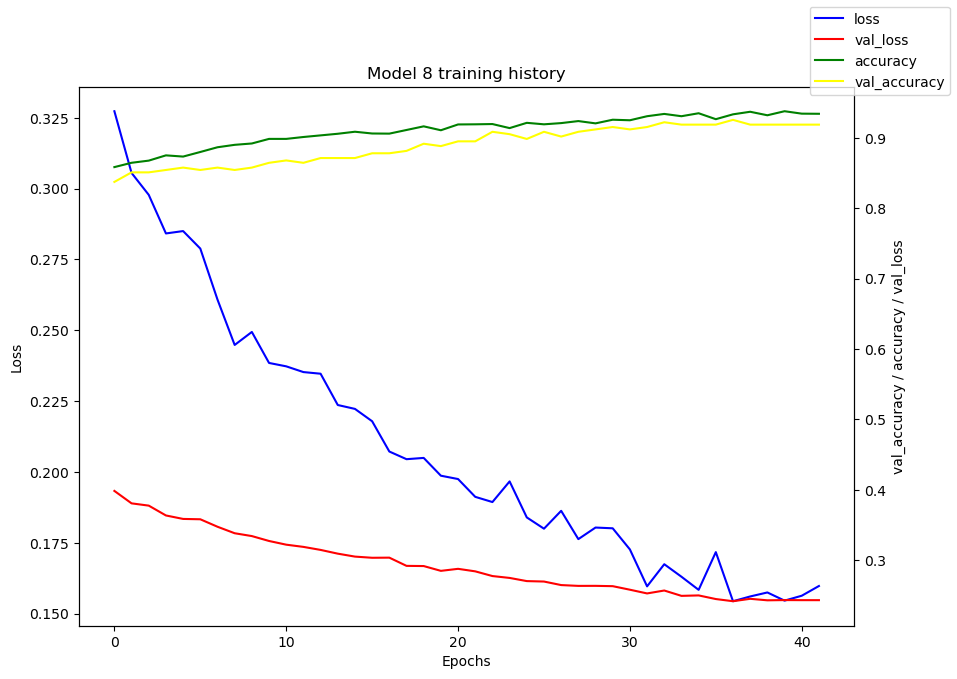

In [43]:
HelperFunctions.model_history_plotter(model_8_history, 'Model 8 training history')

In [49]:
del(model_8)
HelperFunctions.clear_backend_gc()

3/3 [==============================] - 4s 940ms/step
Model probability predictions (first 10): [0.07340416 0.04403464 0.26444474 0.14617124 0.622972   0.13585672
 0.06200993 0.39060923 0.3111861  0.15614548]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
3/3 [==============================] - 4s 911ms/step - loss: 0.2950 - accuracy: 0.8696
Sklearn accuracy score: 0.8695652173913043
{'model_8_efficient_net_fine_tuned': {'precision': 0.8761061946902655, 'recall': 0.9209302325581395, 'f_score': 0.8979591836734694, 'accuracy': 0.8695651888847351, 'true_negative_rate': 0.7846154}}


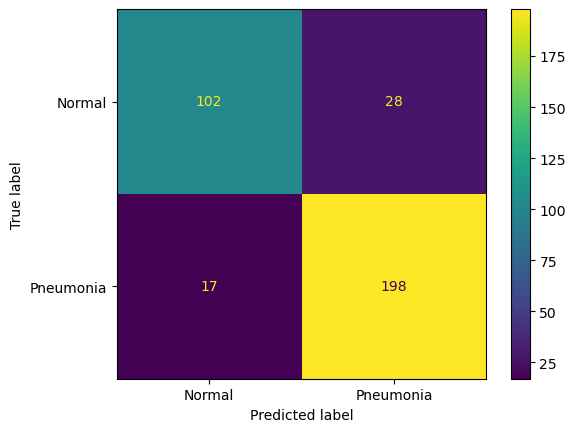

In [34]:
model_8_loaded = tf.keras.models.load_model('model_8_efficient_net_fine_tuned')
HelperFunctions.model_evaluator(model_8_loaded, test_dataset, model_name='model_8_efficient_net_fine_tuned')

In [35]:
del model_8_loaded
HelperFunctions.clear_backend_gc()

# Model 9: ResNet model (transfer learning)

***

Given that ResNet has been widely used for medical imaging, it's worth a try here.  

Let's keep the dropout and image augmentation in previous models

***

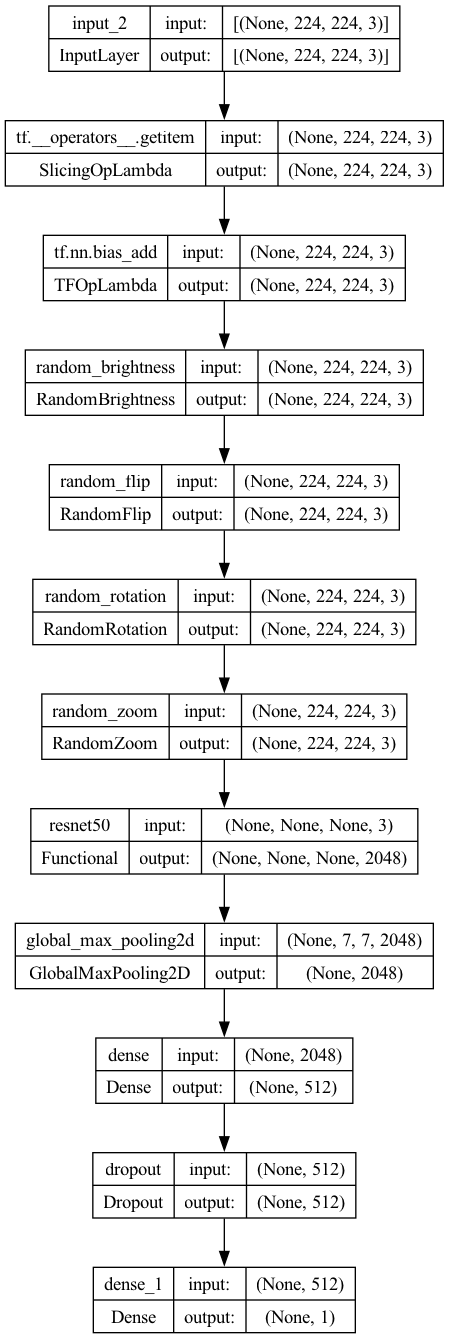

In [36]:
resnet = tf.keras.applications.ResNet50(include_top=False)
resnet.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = tf.keras.layers.RandomBrightness(0.2)(x)
x = tf.keras.layers.RandomFlip('horizontal')(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)
x = resnet(x, training=False)
x = tf.keras.layers.GlobalMaxPool2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_9 = tf.keras.Model(inputs, outputs, name='model_9_resnet')

model_9.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

tf.keras.utils.plot_model(model_9, show_shapes=True)

In [41]:
model_9_history = model_9.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2),
    tf.keras.callbacks.ModelCheckpoint(model_9.name, save_best_only=True)
    ], class_weight=class_weights_dict)

Epoch 1/50


41/41 [==============================] - ETA: 0s - loss: 4.4477 - accuracy: 0.7048INFO:tensorflow:Assets written to: model_9_resnet/assets


INFO:tensorflow:Assets written to: model_9_resnet/assets


41/41 [==============================] - 135s 3s/step - loss: 4.4477 - accuracy: 0.7048 - val_loss: 1.2959 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8926INFO:tensorflow:Assets written to: model_9_resnet/assets


INFO:tensorflow:Assets written to: model_9_resnet/assets


41/41 [==============================] - 131s 3s/step - loss: 0.2844 - accuracy: 0.8926 - val_loss: 0.4596 - val_accuracy: 0.7729 - lr: 0.0010
Epoch 3/50
41/41 [==============================] - 117s 3s/step - loss: 0.2397 - accuracy: 0.9028 - val_loss: 0.7103 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 4/50
41/41 [==============================] - 118s 3s/step - loss: 0.2174 - accuracy: 0.9086 - val_loss: 0.7627 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 5/50
41/41 [==============================] - 116s 3s/step - loss: 0.2117 - accuracy: 0.9118 - val_loss: 0.7445 - val_accuracy: 0.7153 - lr: 1.0000e-04
Epoch 6/50
41/41 [==============================] - 116s 3s/step - loss: 0.2204 - accuracy: 0.9160 - val_loss: 0.6877 - val_accuracy: 0.7288 - lr: 1.0000e-04
Epoch 7/50
41/41 [==============================] - 113s 3s/step - loss: 0.1966 - accuracy: 0.9178 - val_loss: 0.6987 - val_accuracy: 0.7254 - lr: 1.0000e-05


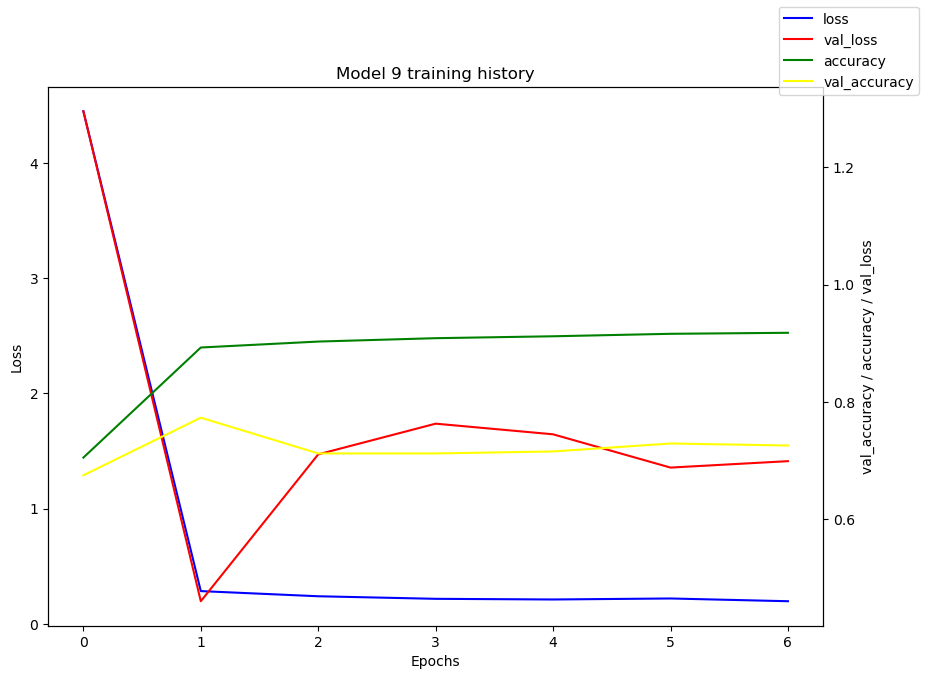

In [42]:
HelperFunctions.model_history_plotter(model_9_history, 'Model 9 training history')

In [43]:
del model_9
HelperFunctions.clear_backend_gc()

3/3 [==============================] - 7s 2s/step
Model probability predictions (first 10): [0.40548503 0.4066479  0.84222394 0.82368666 0.94703895 0.43393657
 0.8608674  0.7749906  0.69776857 0.9272365 ]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
3/3 [==============================] - 7s 2s/step - loss: 0.4959 - accuracy: 0.7623
Sklearn accuracy score: 0.7623188405797101
{'model_9_resnet': {'precision': 0.7418181818181818, 'recall': 0.9488372093023256, 'f_score': 0.8326530612244898, 'accuracy': 0.7623188495635986, 'true_negative_rate': 0.45384616}}


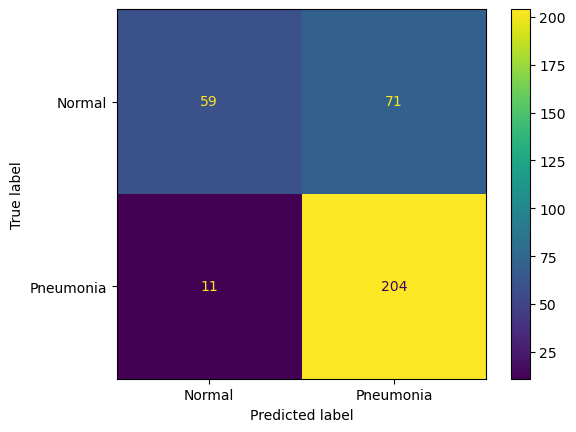

In [35]:
model_9_loaded = tf.keras.models.load_model('model_9_resnet')
HelperFunctions.model_evaluator(model_9_loaded, test_dataset, model_name='model_9_resnet')

In [36]:
del model_9_loaded
HelperFunctions.clear_backend_gc()

# Model 10: MobileNetV2

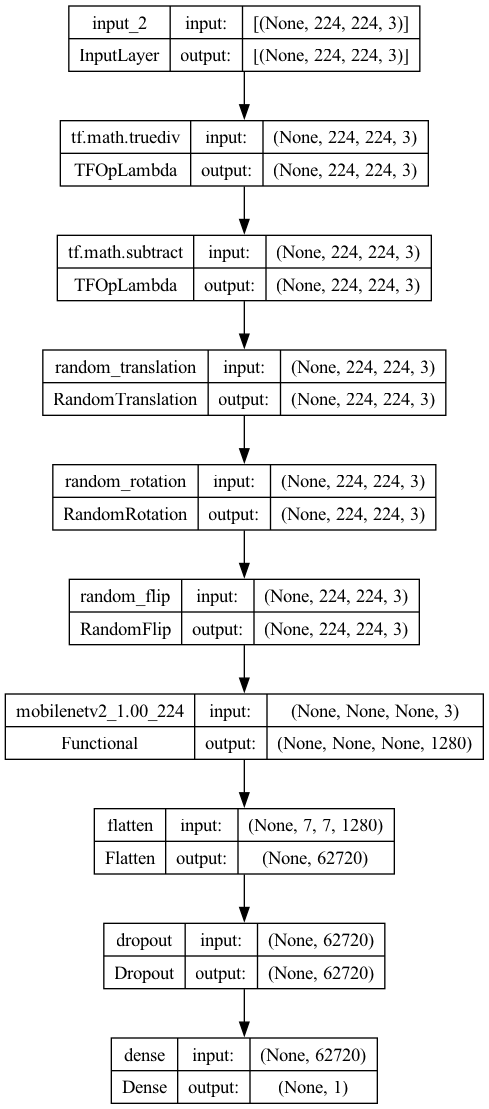

In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=False)
mobilenet.trainable = True
mobilenet_prep = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = mobilenet_prep(inputs)
x = tf.keras.layers.RandomTranslation(0.2, 0.2)(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomFlip('horizontal')(x)
x = mobilenet(x, training=True)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_10 = tf.keras.Model(inputs, outputs, name='model_10_mobilenetV2')

model_10.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), metrics=['accuracy'])

tf.keras.utils.plot_model(model_10, show_shapes=True)

In [ ]:
model_10_history = model_10.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[
    # tf.keras.callbacks.EarlyStopping(patience=5),
    # tf.keras.callbacks.ReduceLROnPlateau(patience=2),
    tf.keras.callbacks.ModelCheckpoint(model_10.name, save_best_only=True)
    ], class_weight=class_weights_dict)

Epoch 1/20


326/326 [==============================] - ETA: 0s - loss: 2.5232 - accuracy: 0.8558INFO:tensorflow:Assets written to: model_10_mobilenetV2/assets


INFO:tensorflow:Assets written to: model_10_mobilenetV2/assets


326/326 [==============================] - 48s 141ms/step - loss: 2.5232 - accuracy: 0.8558 - val_loss: 4.3249 - val_accuracy: 0.8203
Epoch 2/20
326/326 [==============================] - 33s 101ms/step - loss: 2.8260 - accuracy: 0.8917 - val_loss: 7.6945 - val_accuracy: 0.7932
Epoch 3/20
326/326 [==============================] - 34s 103ms/step - loss: 2.8451 - accuracy: 0.9068 - val_loss: 4.3941 - val_accuracy: 0.8407
Epoch 4/20
326/326 [==============================] - 34s 105ms/step - loss: 2.6953 - accuracy: 0.9120 - val_loss: 12.9644 - val_accuracy: 0.7559
Epoch 5/20
326/326 [==============================] - 34s 105ms/step - loss: 2.9348 - accuracy: 0.9086 - val_loss: 6.1128 - val_accuracy: 0.8339
Epoch 6/20
326/326 [==============================] - ETA: 0s - loss: 2.8761 - accuracy: 0.9179INFO:tensorflow:Assets written to: model_10_mobilenetV2/assets


INFO:tensorflow:Assets written to: model_10_mobilenetV2/assets


326/326 [==============================] - 46s 139ms/step - loss: 2.8761 - accuracy: 0.9179 - val_loss: 2.8851 - val_accuracy: 0.8881
Epoch 7/20
326/326 [==============================] - 33s 101ms/step - loss: 2.9549 - accuracy: 0.9147 - val_loss: 8.2584 - val_accuracy: 0.8305
Epoch 8/20
326/326 [==============================] - 33s 101ms/step - loss: 2.9413 - accuracy: 0.9181 - val_loss: 3.5832 - val_accuracy: 0.8881
Epoch 9/20
326/326 [==============================] - 33s 101ms/step - loss: 2.7207 - accuracy: 0.9260 - val_loss: 5.0353 - val_accuracy: 0.8644
Epoch 10/20
326/326 [==============================] - 33s 101ms/step - loss: 3.2480 - accuracy: 0.9158 - val_loss: 7.5116 - val_accuracy: 0.8508
Epoch 11/20
326/326 [==============================] - 33s 101ms/step - loss: 3.0881 - accuracy: 0.9227 - val_loss: 7.7552 - val_accuracy: 0.8407
Epoch 12/20
326/326 [==============================] - 35s 107ms/step - loss: 2.6676 - accuracy: 0.9264 - val_loss: 8.0803 - val_accuracy: 

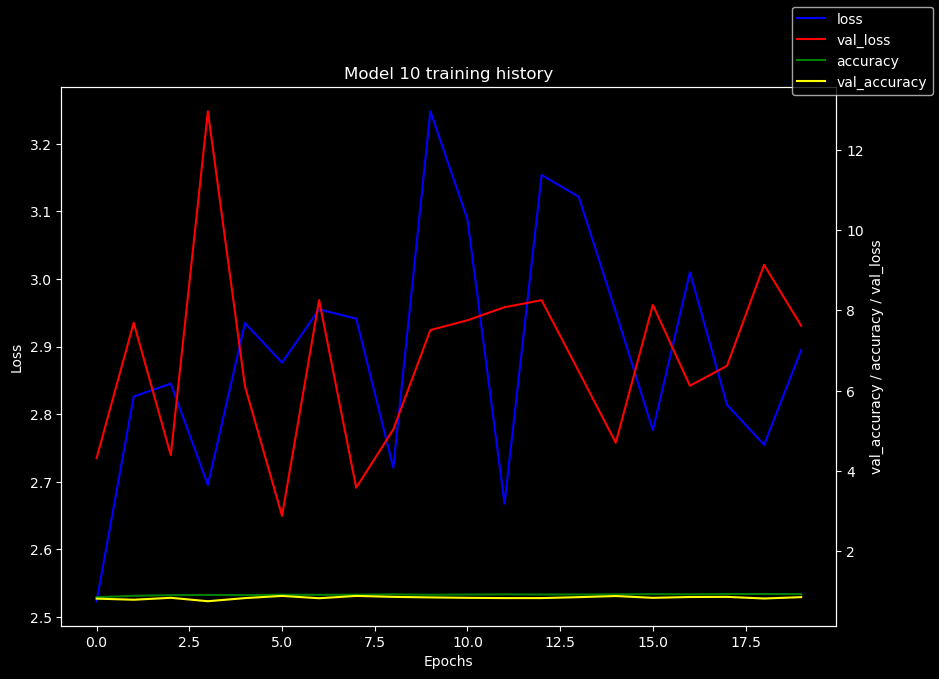

In [ ]:
HelperFunctions.model_history_plotter(model_10_history, 'Model 10 training history')

In [ ]:
del model_10
HelperFunctions.clear_backend_gc()

3/3 [==============================] - 2s 532ms/step
Model probability predictions (first 10): [0.0000000e+00 1.4346443e-21 7.0324120e-25 1.0758959e-24 2.7283096e-07
 0.0000000e+00 3.0848381e-15 0.0000000e+00 1.7888846e-23 5.6189949e-33]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
3/3 [==============================] - 3s 553ms/step - loss: 3.7327 - accuracy: 0.8986
Sklearn accuracy score: 0.8985507246376812
{'model_10_mobilenetV2': {'precision': 0.8879310344827587, 'recall': 0.958139534883721, 'f_score': 0.9217002237136466, 'accuracy': 0.8985507488250732, 'true_negative_rate': 0.8}}


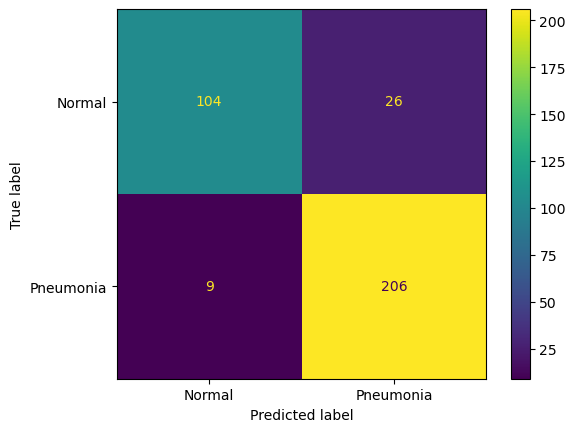

In [44]:
model_10_loaded: tf.keras.Model = tf.keras.models.load_model('model_10_mobilenetV2')
HelperFunctions.model_evaluator(model_10_loaded, test_dataset)

In [45]:
del model_10_loaded
HelperFunctions.clear_backend_gc()

# Model 11: MobileNetV2 (train all layers)

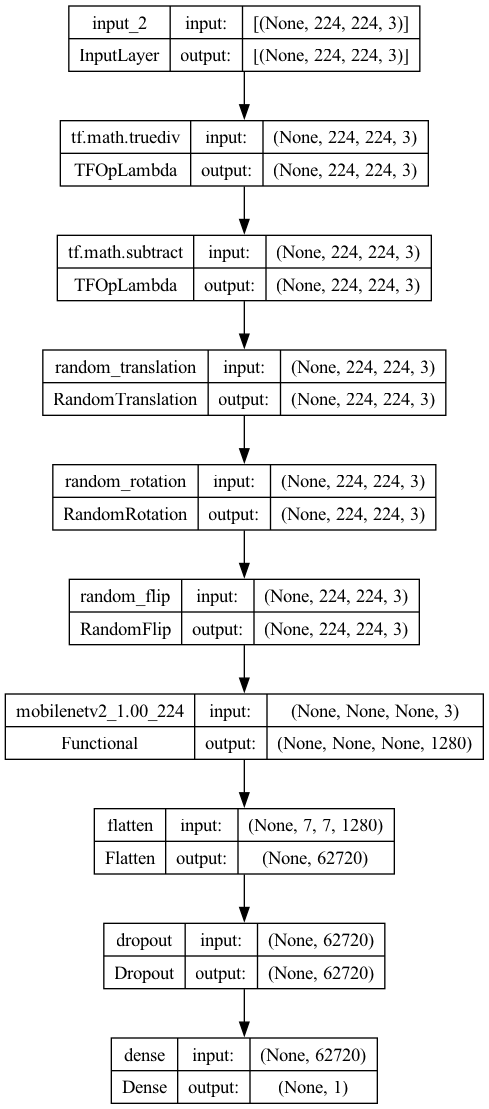

In [ ]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=False)
mobilenet.trainable = True
mobilenet_prep = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = mobilenet_prep(inputs)
x = tf.keras.layers.RandomTranslation(0.2, 0.2)(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomFlip('horizontal')(x)
x = mobilenet(x, training=True)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_11 = tf.keras.Model(inputs, outputs, name='model_11_mobilenetV2_train_all')

model_11.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), metrics=['accuracy'])

tf.keras.utils.plot_model(model_11, show_shapes=True)

In [ ]:
model_11_history = model_11.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(model_11.name, save_best_only=True)
    ], class_weight=class_weights_dict)

Epoch 1/20
326/326 [==============================] - ETA: 0s - loss: 0.7425 - accuracy: 0.8390INFO:tensorflow:Assets written to: model_11_mobilenetV2_train_all/assets


INFO:tensorflow:Assets written to: model_11_mobilenetV2_train_all/assets


326/326 [==============================] - 154s 459ms/step - loss: 0.7425 - accuracy: 0.8390 - val_loss: 1.9948 - val_accuracy: 0.7322
Epoch 2/20
326/326 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.8255INFO:tensorflow:Assets written to: model_11_mobilenetV2_train_all/assets


INFO:tensorflow:Assets written to: model_11_mobilenetV2_train_all/assets


326/326 [==============================] - 156s 478ms/step - loss: 0.6929 - accuracy: 0.8255 - val_loss: 0.4250 - val_accuracy: 0.8136
Epoch 3/20
326/326 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.8781INFO:tensorflow:Assets written to: model_11_mobilenetV2_train_all/assets


INFO:tensorflow:Assets written to: model_11_mobilenetV2_train_all/assets


326/326 [==============================] - 156s 477ms/step - loss: 0.3748 - accuracy: 0.8781 - val_loss: 0.3547 - val_accuracy: 0.8712
Epoch 4/20
326/326 [==============================] - 137s 420ms/step - loss: 0.2722 - accuracy: 0.8944 - val_loss: 0.4094 - val_accuracy: 0.8678
Epoch 5/20
326/326 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.9043INFO:tensorflow:Assets written to: model_11_mobilenetV2_train_all/assets


INFO:tensorflow:Assets written to: model_11_mobilenetV2_train_all/assets


326/326 [==============================] - 148s 453ms/step - loss: 0.2569 - accuracy: 0.9043 - val_loss: 0.3053 - val_accuracy: 0.8915
Epoch 6/20
326/326 [==============================] - 136s 418ms/step - loss: 0.6429 - accuracy: 0.8760 - val_loss: 1.0295 - val_accuracy: 0.7254
Epoch 7/20
326/326 [==============================] - 135s 412ms/step - loss: 0.8021 - accuracy: 0.7899 - val_loss: 1.1243 - val_accuracy: 0.7898
Epoch 8/20
326/326 [==============================] - 134s 411ms/step - loss: 0.4468 - accuracy: 0.8457 - val_loss: 1.5041 - val_accuracy: 0.8373
Epoch 9/20
326/326 [==============================] - 136s 418ms/step - loss: 0.4081 - accuracy: 0.8482 - val_loss: 0.4119 - val_accuracy: 0.8339
Epoch 10/20
326/326 [==============================] - 137s 421ms/step - loss: 1.0419 - accuracy: 0.8365 - val_loss: 1.2318 - val_accuracy: 0.8271


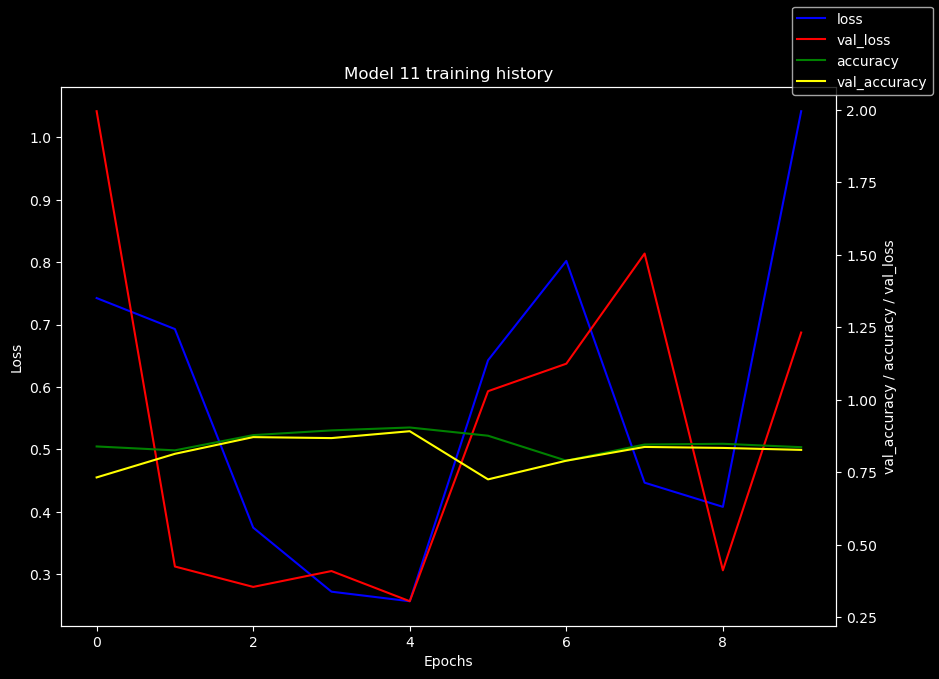

In [ ]:
HelperFunctions.model_history_plotter(model_11_history, 'Model 11 training history')

In [ ]:
del model_11
HelperFunctions.clear_backend_gc()

3/3 [==============================] - 4s 1s/step
Model probability predictions (first 10): [0.01871339 0.0981134  0.10464123 0.52104634 0.8069851  0.4298098
 0.36355144 0.4433249  0.9598377  0.02667506]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
3/3 [==============================] - 4s 1s/step - loss: 3.5795 - accuracy: 0.6203
Sklearn accuracy score: 0.6202898550724638
{'model_11_mobilenetV2_train_all': {'precision': 0.6779661016949152, 'recall': 0.7441860465116279, 'f_score': 0.7095343680709535, 'accuracy': 0.6202898621559143, 'true_negative_rate': 0.41538462}}


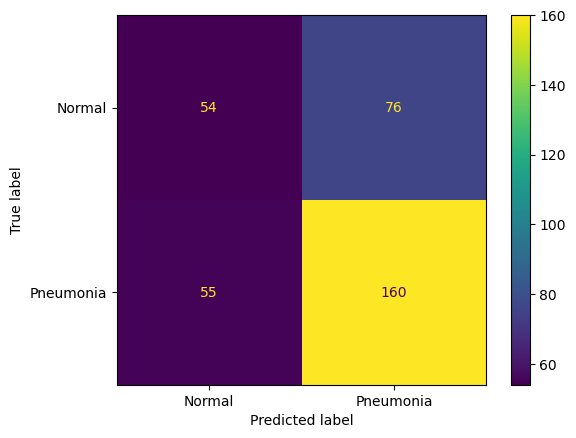

In [46]:
model_11_loaded: tf.keras.Model = tf.keras.models.load_model('model_11_mobilenetV2_train_all')
HelperFunctions.model_evaluator(model_11_loaded, test_dataset, 'model_11_mobilenetV2_train_all')

In [47]:
del model_11_loaded
HelperFunctions.clear_backend_gc()

# Models analysis

## Read in model metrics and visualise

In [37]:
df = pd.read_json('model_results.json', orient='index')

In [38]:
df

,precision,recall,f_score,accuracy,true_negative_rate
model_1_fully_dense,0.623188,1.000000,0.767857,0.623188,0.000000
model_2_convolutional,0.723549,0.986047,0.834646,0.756522,0.376923
model_3_CNN_augmentation_dropout_weighted,0.699115,0.734884,0.716553,0.637681,0.476923
model_4_Medium_CNN_weighted_dropout_scaled,0.769517,0.962791,0.855372,0.797101,0.523077
model_5_Simple_CNN_augmentation_dropout_weighted_scaled,0.891089,0.837209,0.863309,0.834783,0.830769
model_6_efficient_net,0.820717,0.958140,0.884120,0.843478,0.653846
model_7_efficient_net_dropout_augmentation,0.835443,0.920930,0.876106,0.837681,0.700000
model_8_efficient_net_fine_tuned,0.876106,0.920930,0.897959,0.869565,0.784615
model_9_resnet,0.741818,0.948837,0.832653,0.762319,0.453846
model_10_mobilenetV2,0.887931,0.958140,0.921700,0.898551,0.800000


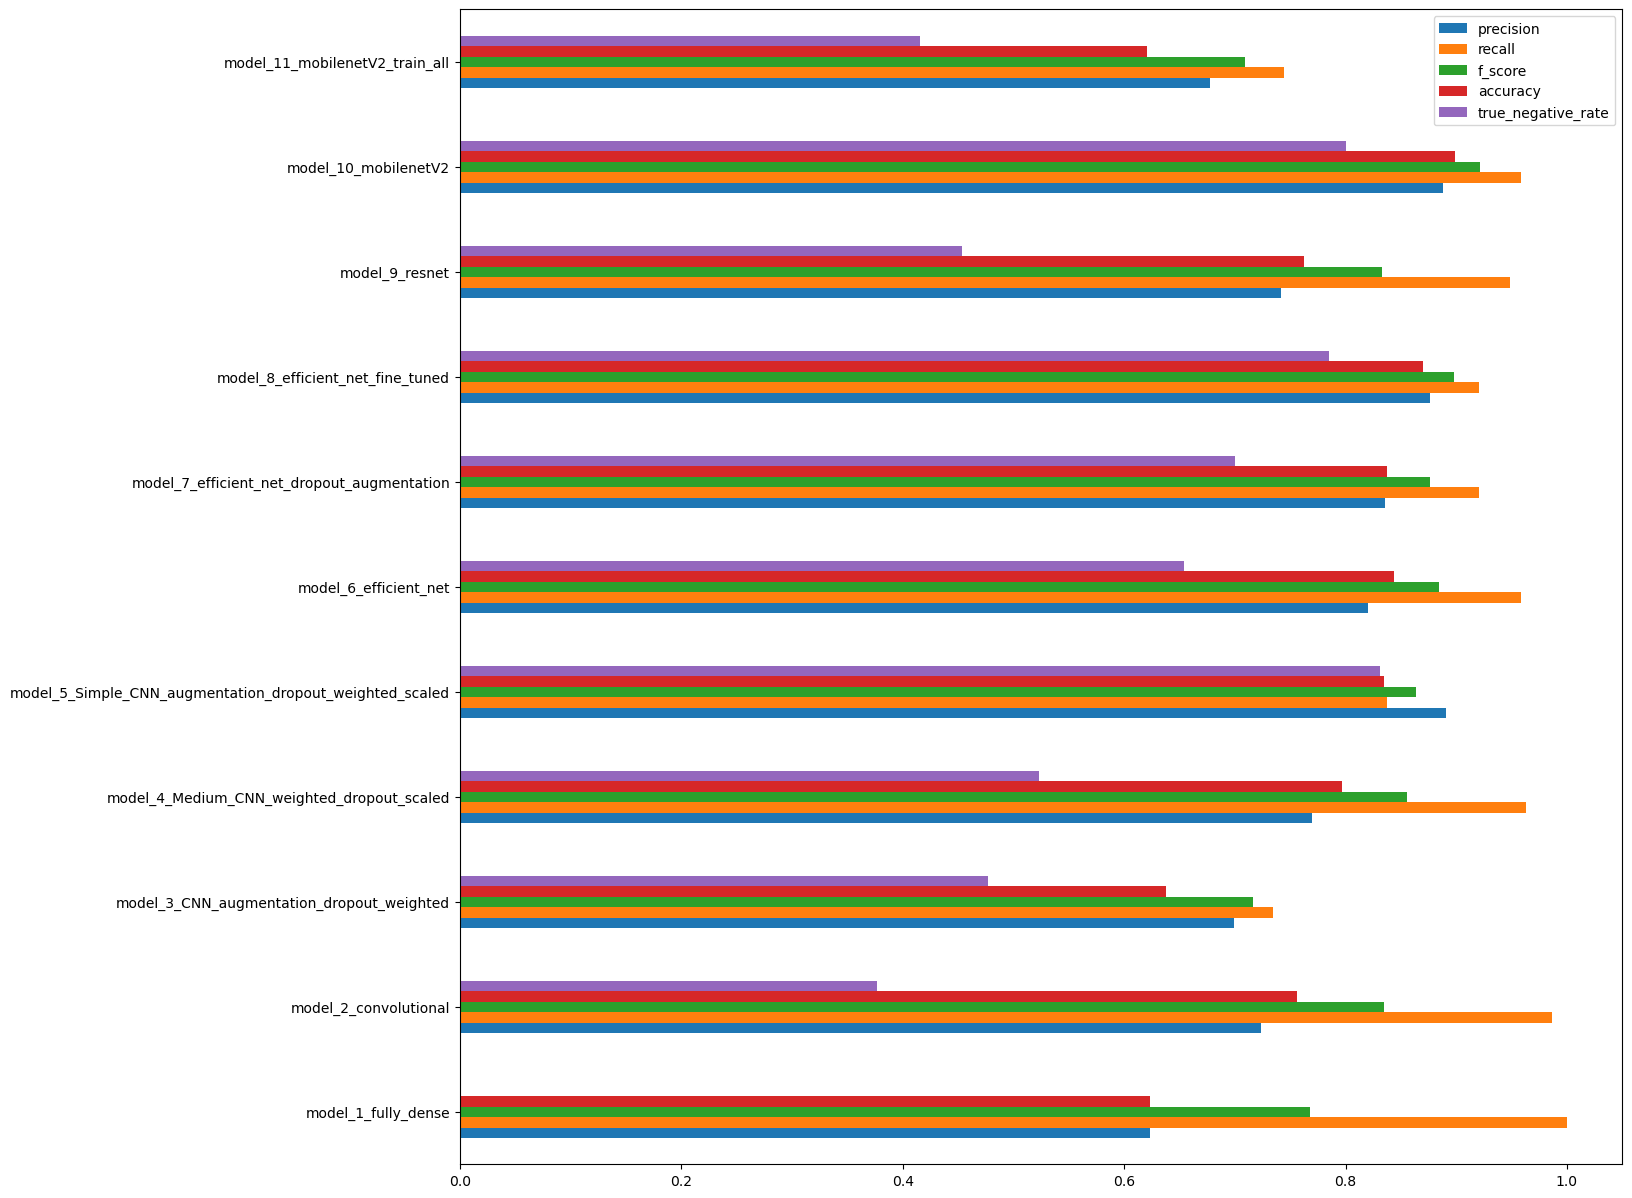

In [39]:
df.plot(kind='barh', figsize=(15, 15))
# plt.xticks(rotation=45)
plt.show()

***

Let's make a mean of the various metrics to try and find the best models

***

In [40]:
df['Mean'] = df.mean(axis=1)
df.sort_values(by='Mean', axis=0, ascending=False)

,precision,recall,f_score,accuracy,true_negative_rate,Mean
model_10_mobilenetV2,0.887931,0.958140,0.921700,0.898551,0.800000,0.893264
model_8_efficient_net_fine_tuned,0.876106,0.920930,0.897959,0.869565,0.784615,0.869835
model_5_Simple_CNN_augmentation_dropout_weighted_scaled,0.891089,0.837209,0.863309,0.834783,0.830769,0.851432
model_7_efficient_net_dropout_augmentation,0.835443,0.920930,0.876106,0.837681,0.700000,0.834032
model_6_efficient_net,0.820717,0.958140,0.884120,0.843478,0.653846,0.832060
model_4_Medium_CNN_weighted_dropout_scaled,0.769517,0.962791,0.855372,0.797101,0.523077,0.781572
model_9_resnet,0.741818,0.948837,0.832653,0.762319,0.453846,0.747895
model_2_convolutional,0.723549,0.986047,0.834646,0.756522,0.376923,0.735537
model_3_CNN_augmentation_dropout_weighted,0.699115,0.734884,0.716553,0.637681,0.476923,0.653031
model_11_mobilenetV2_train_all,0.677966,0.744186,0.709534,0.620290,0.415385,0.633472


# Ensemble model

In [41]:
model_10_loaded = tf.keras.models.load_model('model_10_mobilenetV2')
model_8_loaded = tf.keras.models.load_model('model_8_efficient_net_fine_tuned')
model_5_loaded = tf.keras.models.load_model('model_5_Simple_CNN_augmentation_dropout_weighted_scaled')

In [44]:
ensemble_inputs = tf.keras.layers.Input(shape=(224, 224, 3))

model_10_outputs = model_10_loaded(ensemble_inputs)
model_8_outputs = model_8_loaded(ensemble_inputs)
model_5_outputs = model_5_loaded(ensemble_inputs)

stacked_outputs = tf.stack([model_10_outputs, model_8_outputs, model_5_outputs])
average_output = tf.reduce_mean(stacked_outputs, axis=0)

ensemble_model = tf.keras.Model(ensemble_inputs, average_output, name='ensemble_model')

ensemble_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) # needed to run model.evaluate()

3/3 [==============================] - 5s 1s/step
Model probability predictions (first 10): [0.17713456 0.27578804 0.11688449 0.11498523 0.30703673 0.12080725
 0.08586629 0.2593266  0.24694228 0.06083179]
True labels (first 10): [0 0 0 0 0 0 0 0 0 0]
3/3 [==============================] - 7s 1s/step - loss: 0.2546 - accuracy: 0.9072
Sklearn accuracy score: 0.9072463768115943
{'ensemble_model': {'precision': 0.9030837004405287, 'recall': 0.9534883720930233, 'f_score': 0.9276018099547512, 'accuracy': 0.9072463512420654, 'true_negative_rate': 0.83076924}}


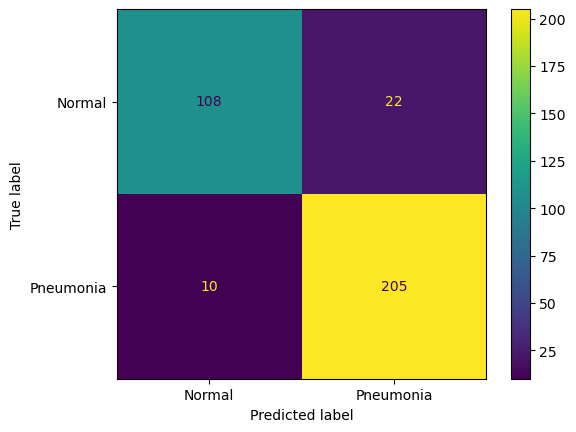

In [45]:
HelperFunctions.model_evaluator(ensemble_model, test_dataset, 'ensemble_model')

# Review metrics with ensemble model added

In [48]:
df = pd.read_json('model_results.json', orient='index')
df

,precision,recall,f_score,accuracy,true_negative_rate
model_1_fully_dense,0.623188,1.000000,0.767857,0.623188,0.000000
model_2_convolutional,0.723549,0.986047,0.834646,0.756522,0.376923
model_3_CNN_augmentation_dropout_weighted,0.699115,0.734884,0.716553,0.637681,0.476923
model_4_Medium_CNN_weighted_dropout_scaled,0.769517,0.962791,0.855372,0.797101,0.523077
model_5_Simple_CNN_augmentation_dropout_weighted_scaled,0.891089,0.837209,0.863309,0.834783,0.830769
model_6_efficient_net,0.820717,0.958140,0.884120,0.843478,0.653846
model_7_efficient_net_dropout_augmentation,0.835443,0.920930,0.876106,0.837681,0.700000
model_8_efficient_net_fine_tuned,0.876106,0.920930,0.897959,0.869565,0.784615
model_9_resnet,0.741818,0.948837,0.832653,0.762319,0.453846
model_10_mobilenetV2,0.887931,0.958140,0.921700,0.898551,0.800000


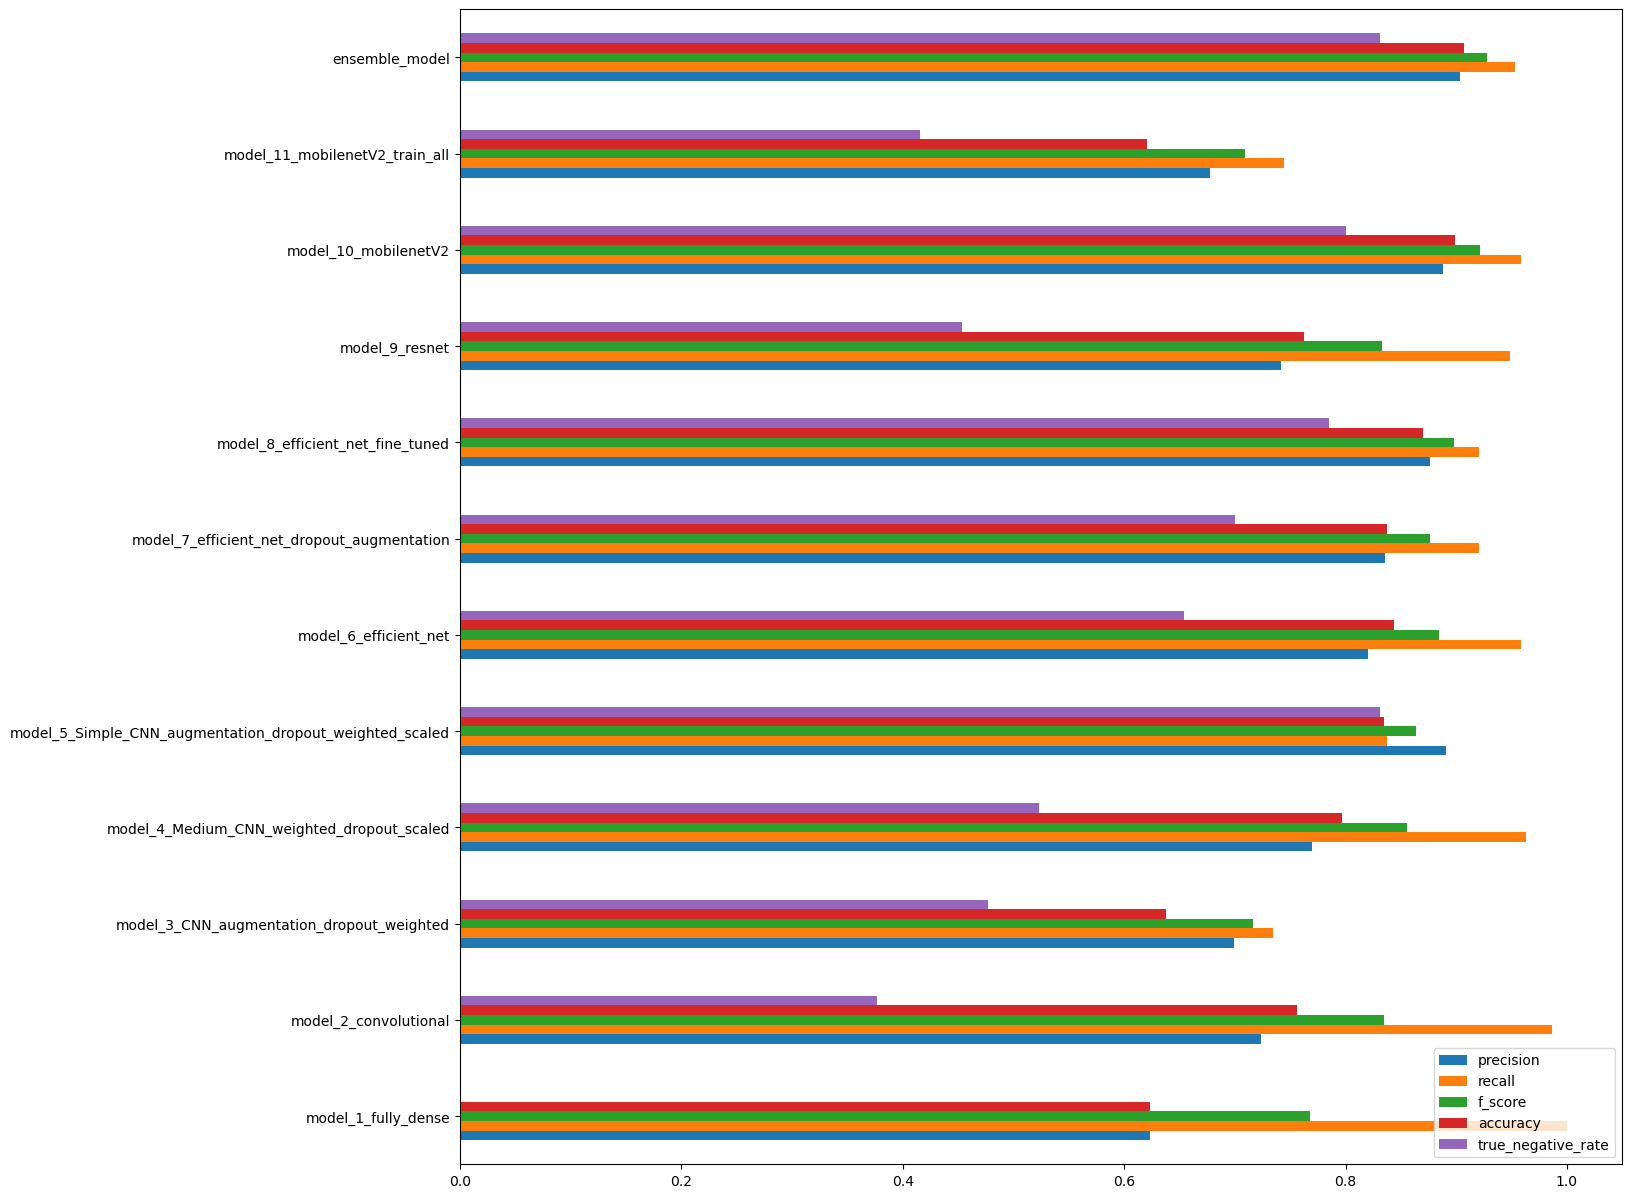

In [49]:
df.plot(kind='barh', figsize=(15, 15))
plt.show()

In [50]:
df['Mean'] = df.mean(axis=1)
df.sort_values(by='Mean', axis=0, ascending=False)

,precision,recall,f_score,accuracy,true_negative_rate,Mean
ensemble_model,0.903084,0.953488,0.927602,0.907246,0.830769,0.904438
model_10_mobilenetV2,0.887931,0.958140,0.921700,0.898551,0.800000,0.893264
model_8_efficient_net_fine_tuned,0.876106,0.920930,0.897959,0.869565,0.784615,0.869835
model_5_Simple_CNN_augmentation_dropout_weighted_scaled,0.891089,0.837209,0.863309,0.834783,0.830769,0.851432
model_7_efficient_net_dropout_augmentation,0.835443,0.920930,0.876106,0.837681,0.700000,0.834032
model_6_efficient_net,0.820717,0.958140,0.884120,0.843478,0.653846,0.832060
model_4_Medium_CNN_weighted_dropout_scaled,0.769517,0.962791,0.855372,0.797101,0.523077,0.781572
model_9_resnet,0.741818,0.948837,0.832653,0.762319,0.453846,0.747895
model_2_convolutional,0.723549,0.986047,0.834646,0.756522,0.376923,0.735537
model_3_CNN_augmentation_dropout_weighted,0.699115,0.734884,0.716553,0.637681,0.476923,0.653031


***

<h1>The ensemble model has the highest mean of all metrics</h1>

***

# Comments

The ensemble model, consisting of models 5, 8, and 10, seems to perform the best.  

It has a recall of 0.95, meaning that 95% of pneumonia patients will be identified as having pneumonia using this model.  

It also has a reasonable true negative rate of 83%, meaning that 17% of patients without pneumonia will be incorrectly predicted by the model to have pneumonia. This is likely to be insufficient for the model to be useful in practice in the medical field. However, for a model built with consumer grade computing power, in a matter of hours, using a small dataset, I consider this to be a reasonable result.  

model_1 highlights the importance of utilising several metrics (relevant to the problem) in determining the performance of a model. Although it has a recall of 1, meaning all patients with pneumonia would be classified as such, the TNR confirms that in fact, all patients are predicted to have pneumonia.  

For further improvements, further optimisations of model_10, by way of unfreezing the later layers and performing further training with a low learning rate, could be beneficial. Given the modest improvements in EfficientNet (model_7) once fine tuned, there is room for model_10 to improve further.  

model_5 could also be further optimised. It was kept fairly simple, as increasing the complexity, regularisation, or augmentation of images in this model led to an inability of the model to converge. The utilisation of residuals here could increase efficiency during training by preventing exploding gradients. Despite this, it is interesting that such a simple model can compete with very deep networks such as EfficientNet and MobileNetV2.  

There is the possibility of training the ensemble model further, using a low learning rate. Such a method can vary wildly in terms of increased performance.  